In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

# # Define la ruta a la carpeta en tu Drive donde están tus módulos
# # Asegúrate de CAMBIAR 'mis_modulos' por el nombre real de tu carpeta
module_path1 = '/kaggle/input/eme-ele-pe/pytorch/default/2'
module_path2 = '/kaggle/input/emnist'



sys.path.append(module_path1)
sys.path.append(module_path2)

from metrics import *
from models import *


In [2]:
# Cargar los archivos .npy
X_images = np.load('/kaggle/input/emnist/X_images.npy')
y_images = np.load('/kaggle/input/emnist/y_images.npy')

print(f"X_images shape: {X_images.shape}")
print(f"y_images shape: {y_images.shape}")

X_images shape: (809555, 28, 28)
y_images shape: (809555,)


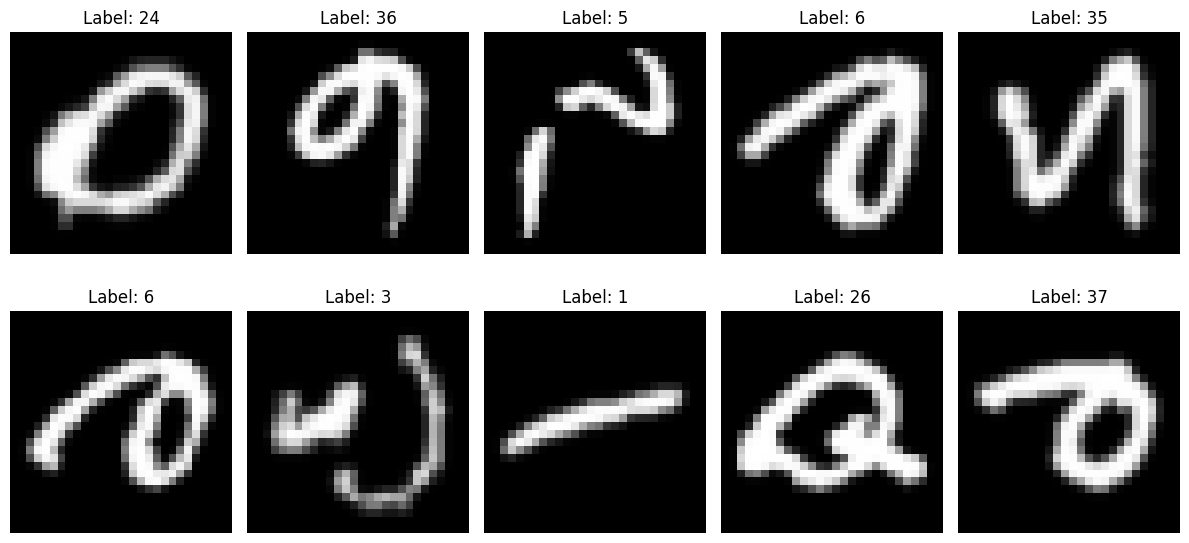

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_images[i], cmap='gray')
    axes[i].set_title(f'Label: {y_images[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Valores únicos: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Cantidad de clases: 47

Primeros 20 valores: [24 36  5  6 35  6  3  1 26 37 39  5  3  7 38 14 28  6 36 46]

=== Distribución de clases ===
Clase 0: 40263 imágenes (4.97%)
Clase 1: 44604 imágenes (5.51%)
Clase 2: 39972 imágenes (4.94%)
Clase 3: 41012 imágenes (5.07%)
Clase 4: 39054 imágenes (4.82%)
Clase 5: 36506 imágenes (4.51%)
Clase 6: 39837 imágenes (4.92%)
Clase 7: 41793 imágenes (5.16%)
Clase 8: 39479 imágenes (4.88%)
Clase 9: 39433 imágenes (4.87%)
Clase 10: 7369 imágenes (0.91%)
Clase 11: 4426 imágenes (0.55%)
Clase 12: 15019 imágenes (1.86%)
Clase 13: 5241 imágenes (0.65%)
Clase 14: 5685 imágenes (0.70%)
Clase 15: 10522 imágenes (1.30%)
Clase 16: 2864 imágenes (0.35%)
Clase 17: 3573 imágenes (0.44%)
Clase 18: 17046 imágenes (2.11%)
Clase 19: 6501 imágenes (0.80%)
Clase 20: 5707 imágenes (0.70%)
Clase 21: 23639 imágenes (

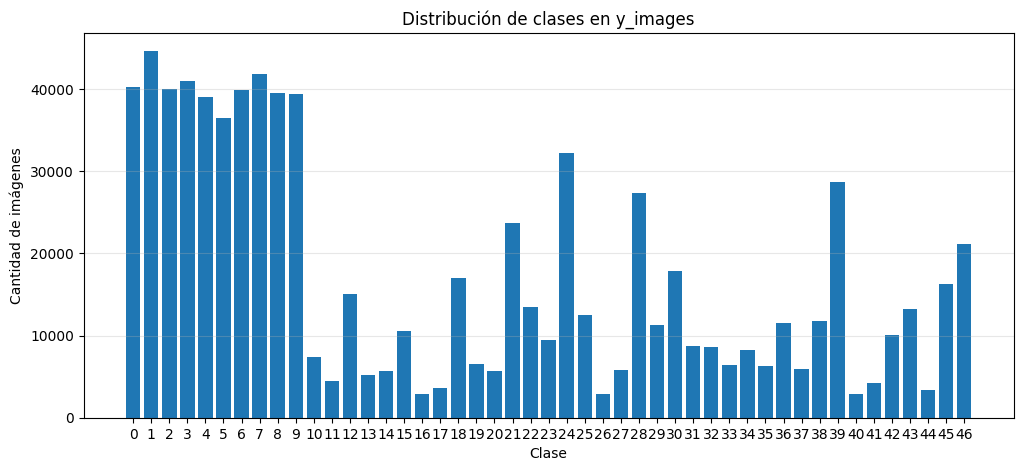

In [4]:

print(f"Valores únicos: {np.unique(y_images)}")
print(f"Cantidad de clases: {len(np.unique(y_images))}")
print(f"\nPrimeros 20 valores: {y_images[:20]}")

unique, counts = np.unique(y_images, return_counts=True)
print("\n=== Distribución de clases ===")
for label, count in zip(unique, counts):
    print(f"Clase {label}: {count} imágenes ({count/len(y_images)*100:.2f}%)")

# Visualizar la distribución
plt.figure(figsize=(12, 5))
plt.bar(unique, counts)
plt.xlabel('Clase')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribución de clases en y_images')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 1. Análisis y Preprocesamiento de Datos

## 1.a) Visualización de imágenes del dataset

=== Visualización de 3 imágenes del dataset ===

Imagen 0: Shape (28, 28), Min=0, Max=255, Clase=24
Imagen 1: Shape (28, 28), Min=0, Max=255, Clase=36
Imagen 2: Shape (28, 28), Min=0, Max=255, Clase=5


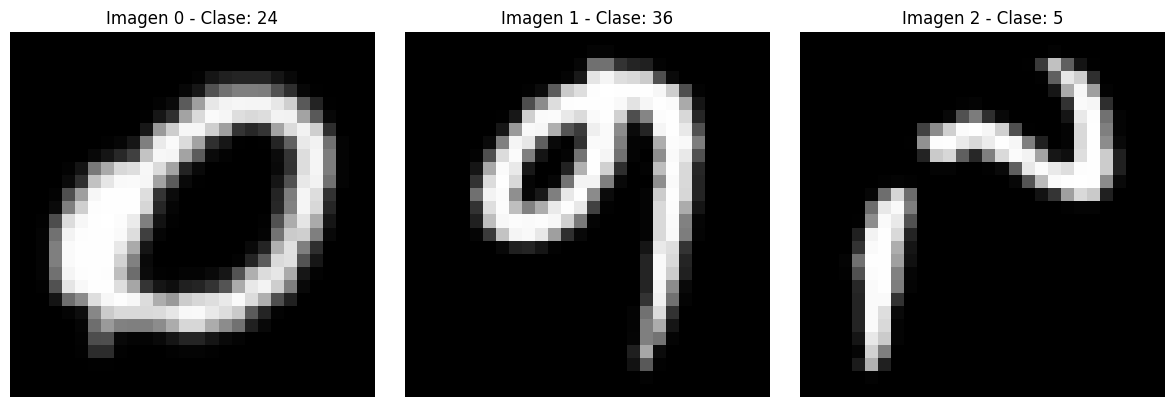

In [5]:
# Visualizar al menos 3 imágenes como pide el ejercicio
print("=== Visualización de 3 imágenes del dataset ===\n")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    img = X_images[i].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Imagen {i} - Clase: {y_images[i]}')
    axes[i].axis('off')
    print(f"Imagen {i}: Shape {img.shape}, Min={img.min()}, Max={img.max()}, Clase={y_images[i]}")

plt.tight_layout()
plt.show()

## 1.b) División del dataset en Train, Validation y Test

In [6]:
# División del dataset
# Proporciones: 70% Train, 15% Validation, 15% Test

np.random.seed(42)  # Para reproducibilidad

# Obtener índices aleatorios
n_samples = X_images.shape[0]
indices = np.random.permutation(n_samples)

# Calcular tamaños
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)
test_size = n_samples - train_size - val_size

# Dividir índices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Crear subconjuntos
X_train = X_images[train_indices]
y_train = y_images[train_indices]

X_val = X_images[val_indices]
y_val = y_images[val_indices]

X_test = X_images[test_indices]
y_test = y_images[test_indices]

print("=== División del dataset ===")
print(f"Train: {X_train.shape[0]} muestras ({X_train.shape[0]/n_samples*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/n_samples*100:.1f}%)")
print(f"Test: {X_test.shape[0]} muestras ({X_test.shape[0]/n_samples*100:.1f}%)")
print(f"Total: {n_samples} muestras")

=== División del dataset ===
Train: 566688 muestras (70.0%)
Validation: 121433 muestras (15.0%)
Test: 121434 muestras (15.0%)
Total: 809555 muestras


## 1.c) Normalización de los datos

In [7]:
# Normalizar dividiendo por 255 para que el máximo sea 1
print("=== Antes de la normalización ===")
print(f"X_train - Min: {X_train.min()}, Max: {X_train.max()}")
print(f"X_val - Min: {X_val.min()}, Max: {X_val.max()}")
print(f"X_test - Min: {X_test.min()}, Max: {X_test.max()}")

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("\n=== Después de la normalización ===")
print(f"X_train - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"X_val - Min: {X_val.min():.4f}, Max: {X_val.max():.4f}")
print(f"X_test - Min: {X_test.min():.4f}, Max: {X_test.max():.4f}")

# Reshape para que sean vectores (flatten) - necesario para MLP
# De (n_samples, 28, 28) a (n_samples, 784)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("\n=== Después del reshape para MLP ===")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_val_flat shape: {X_val_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

# Transponer para que tenga formato (features, samples) como espera nuestro MLP
X_train_T = X_train_flat.T
X_val_T = X_val_flat.T
X_test_T = X_test_flat.T

print("\n=== Transposición para formato (features, samples) ===")
print(f"X_train_T shape: {X_train_T.shape} - (features={X_train_T.shape[0]}, samples={X_train_T.shape[1]})")
print(f"X_val_T shape: {X_val_T.shape}")
print(f"X_test_T shape: {X_test_T.shape}")

=== Antes de la normalización ===
X_train - Min: 0, Max: 255
X_val - Min: 0, Max: 255
X_test - Min: 0, Max: 255

=== Después de la normalización ===
X_train - Min: 0.0000, Max: 1.0000
X_val - Min: 0.0000, Max: 1.0000
X_test - Min: 0.0000, Max: 1.0000

=== Después del reshape para MLP ===
X_train_flat shape: (566688, 784)
X_val_flat shape: (121433, 784)
X_test_flat shape: (121434, 784)

=== Transposición para formato (features, samples) ===
X_train_T shape: (784, 566688) - (features=784, samples=566688)
X_val_T shape: (784, 121433)
X_test_T shape: (784, 121434)


In [8]:
# Convertir labels a one-hot encoding para cross-entropy
def to_one_hot(y, n_classes):
    """Convierte labels a formato one-hot encoding"""
    one_hot = np.zeros((n_classes, y.shape[0]))
    one_hot[y, np.arange(y.shape[0])] = 1
    return one_hot

n_classes = len(np.unique(y_images))
print(f"Número de clases: {n_classes}")

y_train_onehot = to_one_hot(y_train, n_classes)
y_val_onehot = to_one_hot(y_val, n_classes)
y_test_onehot = to_one_hot(y_test, n_classes)

print(f"\ny_train_onehot shape: {y_train_onehot.shape} - (classes={y_train_onehot.shape[0]}, samples={y_train_onehot.shape[1]})")
print(f"y_val_onehot shape: {y_val_onehot.shape}")
print(f"y_test_onehot shape: {y_test_onehot.shape}")

# Verificar que la codificación one-hot está correcta
print("\n=== Verificación de one-hot encoding ===")
print(f"Ejemplo - y_train[0] = {y_train[0]}")
print(f"One-hot correspondiente (primeras 10 posiciones): {y_train_onehot[:10, 0]}")

Número de clases: 47

y_train_onehot shape: (47, 566688) - (classes=47, samples=566688)
y_val_onehot shape: (47, 121433)
y_test_onehot shape: (47, 121434)

=== Verificación de one-hot encoding ===
Ejemplo - y_train[0] = 4
One-hot correspondiente (primeras 10 posiciones): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# 2. Entrenamiento del Modelo MLP con Batch Training

In [9]:
input_size = 784 
n_classes = 47  

L = 2                  
M = [128, 64]          
batch_size = 256     
learning_rate = 0.01   
epochs = 30            
init_method = 'glorot' 

layer_sizes = [input_size] + M + [n_classes]

mlp = MLP(n_layers=L+1, layer_sizes=layer_sizes, batch_size=batch_size, init=init_method)

## 2.c) Entrenamiento del Modelo M0

In [10]:
print("--- Convirtiendo datos a float32 ---")
X_train_T = X_train_T.astype(np.float32)
y_train_onehot = y_train_onehot.astype(np.float32)
X_val_T = X_val_T.astype(np.float32)
y_val_onehot = y_val_onehot.astype(np.float32)
X_test_T = X_test_T.astype(np.float32) # También para el futuro
y_test_onehot = y_test_onehot.astype(np.float32) # También para el futuro

# Verificar (opcional)
print(f"X_train_T dtype: {X_train_T.dtype}")
print(f"y_train_onehot dtype: {y_train_onehot.dtype}")

--- Convirtiendo datos a float32 ---
X_train_T dtype: float32
y_train_onehot dtype: float32


In [11]:
print("=== Iniciando entrenamiento del modelo M0 ===\n")
print(f"Arquitectura: {layer_sizes}")
print(f"Datos de entrenamiento: {X_train_T.shape[1]} muestras")
print(f"Datos de validación: {X_val_T.shape[1]} muestras")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Épocas: {epochs}\n")

import time
start_time = time.time()

history_M0 = mlp.train(
    X_train_T,  
    y_train_onehot,  
    X_val=X_val_T, 
    y_val=y_val_onehot,
    epochs=epochs, 
    learning_rate=learning_rate,
    verbose=True
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n=== Entrenamiento completado ===")
print(f"Tiempo total: {training_time:.2f} segundos ({training_time/60:.2f} minutos)")
print(f"Tiempo por época: {training_time/epochs:.2f} segundos")

import cupy as cp
train_losses = [float(cp.asnumpy(loss)) if isinstance(loss, cp.ndarray) else float(loss) 
                for loss in history_M0['train_loss']]
val_losses = [float(cp.asnumpy(loss)) if isinstance(loss, cp.ndarray) else float(loss) 
              for loss in history_M0['val_loss']]

print(f"\nLoss final - Train: {train_losses[-1]:.4f}, Validation: {val_losses[-1]:.4f}")

=== Iniciando entrenamiento del modelo M0 ===

Arquitectura: [784, 128, 64, 47]
Datos de entrenamiento: 566688 muestras
Datos de validación: 121433 muestras
Batch size: 256
Learning rate: 0.01
Épocas: 30

Epoch 0/30 - LR: 0.010000 - Train Loss: 1.9555 - Val Loss: 1.2245
Epoch 10/30 - LR: 0.010000 - Train Loss: 0.6029 - Val Loss: 0.5848
Epoch 20/30 - LR: 0.010000 - Train Loss: 0.4889 - Val Loss: 0.4845

Training completed. Best validation loss: 0.4426

TRAINING TIME SUMMARY
Total time: 181.16s (3.02 min)
Epochs trained: 30
Time per epoch: 6.04s


=== Entrenamiento completado ===
Tiempo total: 181.32 segundos (3.02 minutos)
Tiempo por época: 6.04 segundos

Loss final - Train: 0.4421, Validation: 0.4426


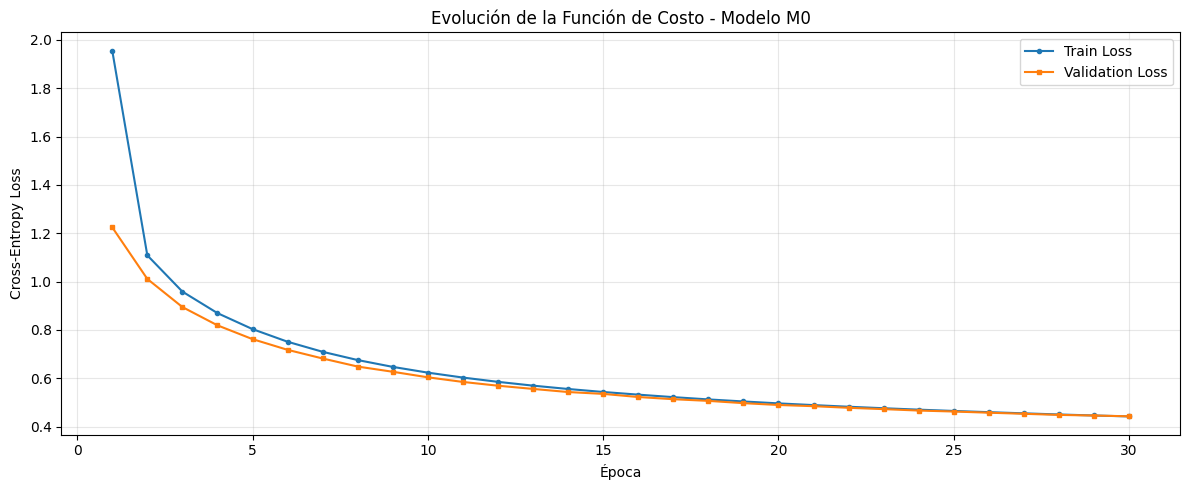

=== Análisis de Convergencia ===
Mejor loss de validación: 0.4426 en época 30
Diferencia train-val al final: 0.0006
✓ Gap train-val aceptable (0.0006)


In [12]:
# Graficar la evolución de la función de costo
plt.figure(figsize=(12, 5))

plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', markersize=3)
plt.xlabel('Época')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución de la Función de Costo - Modelo M0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis de convergencia
print("=== Análisis de Convergencia ===")
print(f"Mejor loss de validación: {min(val_losses):.4f} en época {val_losses.index(min(val_losses))+1}")
print(f"Diferencia train-val al final: {abs(train_losses[-1] - val_losses[-1]):.4f}")

# Detectar posible overfitting
if train_losses[-1] < val_losses[-1]:
    gap = val_losses[-1] - train_losses[-1]
    if gap > 0.1:
        print(f"⚠️ Posible overfitting detectado (gap: {gap:.4f})")
    else:
        print(f"✓ Gap train-val aceptable ({gap:.4f})")
else:
    print("✓ No hay evidencia de overfitting")


Cross-Entropy Final (Train): 0.4421
Cross-Entropy Final (Validation): 0.4426

=== Métricas en Entrenamiento (TRAIN) para M0 ===
metricas
Accuracy: 0.8564 (85.64%)
F1-Score Macro: 0.8079
Precision promedio: 0.8324
Recall promedio: 0.7989

=== Métricas en Validación (VAL) para M0 ===
metricas
Accuracy: 0.8543 (85.43%)
F1-Score Macro: 0.8043
Precision promedio: 0.8286
Recall promedio: 0.7943


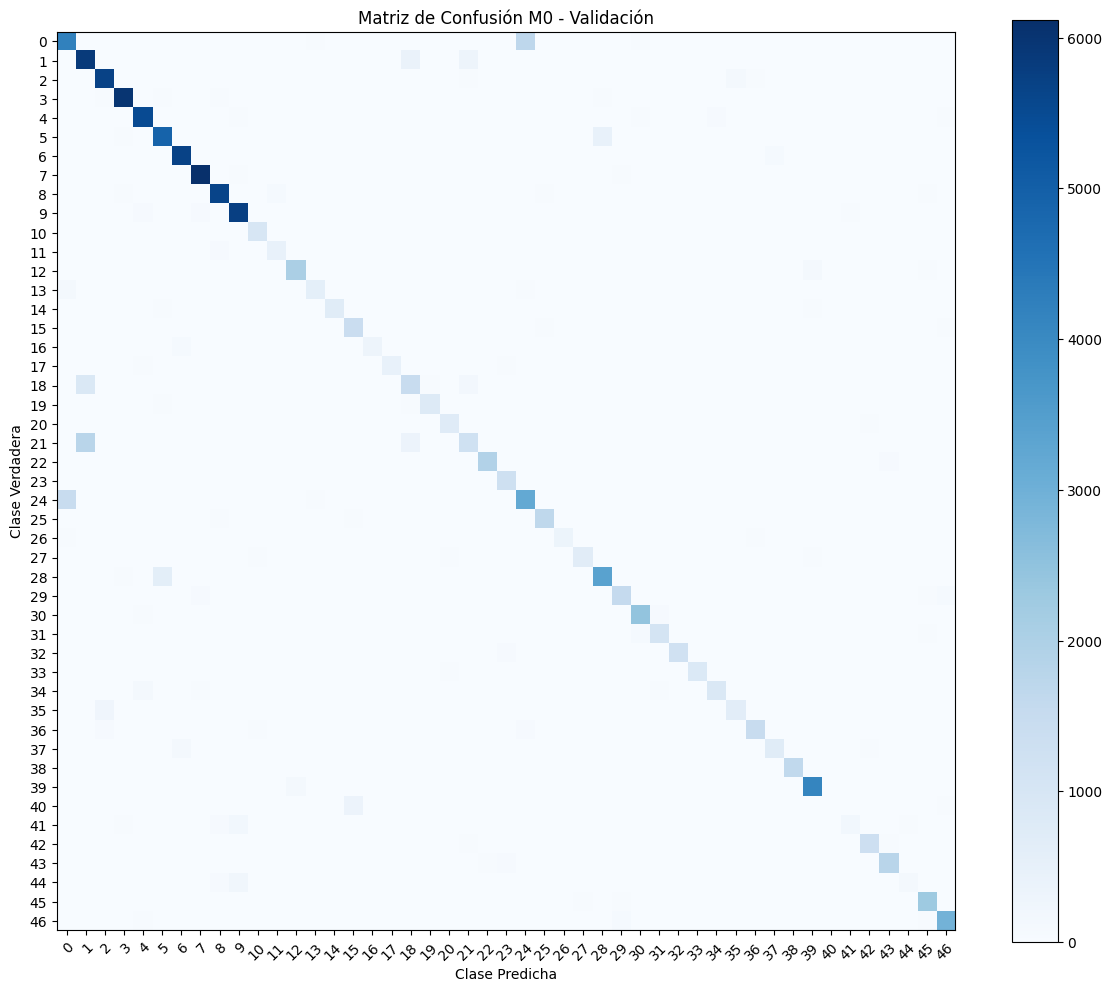

In [13]:



y_pred_train_M0 = mlp.predict(cp.asarray(X_train_T))
y_pred_train_cpu = cp.asnumpy(y_pred_train_M0)

y_pred_val_M0 = mlp.predict(cp.asarray(X_val_T))
y_pred_val_cpu = cp.asnumpy(y_pred_val_M0)

# --- Métricas y Reporte ---

# Reportar Loss (el valor final se toma del entrenamiento en la celda 12)
# Reemplazar con los valores reales si ya ejecutaste la celda 12 y tienes el output
train_loss_final = history_M0['train_loss'][-1]
val_loss_final = history_M0['val_loss'][-1]

print(f"\nCross-Entropy Final (Train): {train_loss_final:.4f}")
print(f"Cross-Entropy Final (Validation): {val_loss_final:.4f}")

print("\n=== Métricas en Entrenamiento (TRAIN) para M0 ===")
metrics_M0_train = evaluate_model(y_train, y_pred_train_cpu, n_classes=n_classes, verbose=True)

print("\n=== Métricas en Validación (VAL) para M0 ===")
metrics_M0_val = evaluate_model(y_val, y_pred_val_cpu, n_classes=n_classes, verbose=True)

plot_confusion_matrix(metrics_M0_val['confusion_matrix'], title='Matriz de Confusión M0 - Validación')
plt.show()



# 3. Modelos Avanzados - Optimizaciones

FALTA REPORTAR TIEMPO DE ENTRENAMIENTO

HAY INCONCISTENCIAS EN LOS HIPERPARAMETROS DE CADA MODELO


In [14]:

# ----------------------------------------------------------------------------
# 2. Learning Rate Scheduling Lineal
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2. LEARNING RATE SCHEDULING LINEAL")
print("="*80)
print("Decay lineal: LR va de 0.01 a 0.001 en 100 épocas (entrenamos 50)\n")
model_linear = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                   batch_size=batch_size, optimizer='sgd')
history_linear = model_linear.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                    epochs=50, learning_rate=0.01,
                                    lr_schedule='linear',
                                    lr_schedule_params={'final_lr': 0.001, 'total_epochs': 100},
                                    verbose=True)



2. LEARNING RATE SCHEDULING LINEAL
Decay lineal: LR va de 0.01 a 0.001 en 100 épocas (entrenamos 50)

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7149 - Val Loss: 3.5154
Epoch 10/50 - LR: 0.009100 - Train Loss: 0.9071 - Val Loss: 0.8674
Epoch 20/50 - LR: 0.008200 - Train Loss: 0.6274 - Val Loss: 0.6114
Epoch 30/50 - LR: 0.007300 - Train Loss: 0.5295 - Val Loss: 0.5194
Epoch 40/50 - LR: 0.006400 - Train Loss: 0.4816 - Val Loss: 0.4765

Training completed. Best validation loss: 0.4540

TRAINING TIME SUMMARY
Total time: 264.80s (4.41 min)
Epochs trained: 50
Time per epoch: 5.30s



In [15]:
# ----------------------------------------------------------------------------
# 3. Learning Rate Scheduling Exponencial
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("3. LEARNING RATE SCHEDULING EXPONENCIAL")
print("="*80)
print("Decay exponencial: LR se multiplica por 0.96 en cada época\n")
model_exp = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                batch_size=batch_size, optimizer='sgd')
history_exp = model_exp.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                              epochs=50, learning_rate=0.01,
                              lr_schedule='exponential',
                              lr_schedule_params={'decay_rate': 0.96},
                              verbose=True)



3. LEARNING RATE SCHEDULING EXPONENCIAL
Decay exponencial: LR se multiplica por 0.96 en cada época

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7250 - Val Loss: 3.5361
Epoch 10/50 - LR: 0.006648 - Train Loss: 1.0062 - Val Loss: 0.9609
Epoch 20/50 - LR: 0.004420 - Train Loss: 0.7193 - Val Loss: 0.7000
Epoch 30/50 - LR: 0.002939 - Train Loss: 0.6307 - Val Loss: 0.6195
Epoch 40/50 - LR: 0.001954 - Train Loss: 0.5903 - Val Loss: 0.5822

Training completed. Best validation loss: 0.5638

TRAINING TIME SUMMARY
Total time: 264.27s (4.40 min)
Epochs trained: 50
Time per epoch: 5.29s



In [16]:
# ----------------------------------------------------------------------------
# 4. Optimizador Adam
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4. OPTIMIZADOR ADAM")
print("="*80)
model_adam = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                 batch_size=batch_size, optimizer='adam')
history_adam = model_adam.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                epochs=50, learning_rate=0.01, verbose=True)



4. OPTIMIZADOR ADAM
Epoch 0/50 - LR: 0.010000 - Train Loss: 0.6818 - Val Loss: 0.5539
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.4926 - Val Loss: 0.5207
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.4860 - Val Loss: 0.4999
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.4804 - Val Loss: 0.5027
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4776 - Val Loss: 0.5119

Training completed. Best validation loss: 0.4938

TRAINING TIME SUMMARY
Total time: 479.21s (7.99 min)
Epochs trained: 50
Time per epoch: 9.58s



In [17]:
# ----------------------------------------------------------------------------
# 5. Regularización L2
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("5. REGULARIZACIÓN L2")
print("="*80)
print("Lambda = 0.01\n")
model_l2 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='sgd')
history_l2 = model_l2.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            lambda_reg=0.01, verbose=True)



5. REGULARIZACIÓN L2
Lambda = 0.01

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7361 - Val Loss: 3.6228
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.9150 - Val Loss: 0.8701
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.6050 - Val Loss: 0.5903
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.5091 - Val Loss: 0.5044
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4615 - Val Loss: 0.4650

Training completed. Best validation loss: 0.4367

TRAINING TIME SUMMARY
Total time: 347.36s (5.79 min)
Epochs trained: 50
Time per epoch: 6.95s



In [18]:

# ----------------------------------------------------------------------------
# 6. Early Stopping
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6. EARLY STOPPING")
print("="*80)
print("Patience = 15 épocas\n")
model_es = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='sgd')
history_es = model_es.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            early_stopping_patience=15, verbose=True)



6. EARLY STOPPING
Patience = 15 épocas

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7303 - Val Loss: 3.5647
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.8878 - Val Loss: 0.8463
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.5954 - Val Loss: 0.5819
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.5023 - Val Loss: 0.5016
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4547 - Val Loss: 0.4539

Training completed. Best validation loss: 0.4297

TRAINING TIME SUMMARY
Total time: 264.67s (4.41 min)
Epochs trained: 50
Time per epoch: 5.29s



In [19]:
print("\n" + "="*80)
print("7. MODELO M1 - Combinación de TODAS las optimizaciones")
print("="*80)
print("Adam + LR Exponencial + L2 Regularization + Early Stopping\n")
model_m1 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='adam')
history_m1 = model_m1.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            lr_schedule='exponential',
                            lr_schedule_params={'decay_rate': 0.95},
                            lambda_reg=0.001,
                            early_stopping_patience=20, verbose=True)


7. MODELO M1 - Combinación de TODAS las optimizaciones
Adam + LR Exponencial + L2 Regularization + Early Stopping

Epoch 0/50 - LR: 0.010000 - Train Loss: 0.6845 - Val Loss: 0.5623
Epoch 10/50 - LR: 0.005987 - Train Loss: 0.4428 - Val Loss: 0.4672
Epoch 20/50 - LR: 0.003585 - Train Loss: 0.3854 - Val Loss: 0.4071
Epoch 30/50 - LR: 0.002146 - Train Loss: 0.3502 - Val Loss: 0.3939
Epoch 40/50 - LR: 0.001285 - Train Loss: 0.3270 - Val Loss: 0.3825

Training completed. Best validation loss: 0.3781

TRAINING TIME SUMMARY
Total time: 529.74s (8.83 min)
Epochs trained: 50
Time per epoch: 10.59s



## Comparación de Modelos - Tabla de Métricas

In [20]:
# ============================================================================
# EVALUACIÓN Y COMPARACIÓN DE TODOS LOS MODELOS
# ============================================================================

def evaluate_model_metrics(model, X_val, y_val_onehot, y_val_true, history, model_name):
    y_pred = model.predict(cp.asarray(X_val))
    y_pred_cpu = cp.asnumpy(y_pred)
    
    acc = accuracy(y_val_true, y_pred_cpu)
    f1_macro, _ = f1_score_macro(y_val_true, y_pred_cpu, n_classes=47)
    precision, recall = precision_recall_per_class(y_val_true, y_pred_cpu, n_classes=47)
    
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    num_epochs = len(history['train_loss'])
    
    return {
        'Modelo': model_name,
        'Train Loss': f"{final_train_loss:.4f}",
        'Val Loss': f"{final_val_loss:.4f}",
        'Accuracy': f"{acc:.4f}",
        'F1-Score': f"{f1_macro:.4f}",
        'Precision': f"{np.mean(precision):.4f}",
        'Recall': f"{np.mean(recall):.4f}",
        'Épocas': num_epochs
    }

models_metrics = []

print("="*80)
print("EVALUANDO TODOS LOS MODELOS EN CONJUNTO DE VALIDACIÓN")
print("="*80 + "\n")

models_to_evaluate = [
    (mlp, history_M0, "M0 - Baseline (SGD)"),
    (model_linear, history_linear, "LR Scheduling Lineal"),
    (model_exp, history_exp, "LR Scheduling Exponencial"),
    (model_adam, history_adam, "Adam"),
    (model_l2, history_l2, "L2 Regularization"),
    (model_es, history_es, "Early Stopping"),
    (model_m1, history_m1, "M1 - Completo (Adam+LR+L2+ES)")
]

for model, history, name in models_to_evaluate:
    print(f"Evaluando: {name}...")
    metrics = evaluate_model_metrics(model, X_val_T, y_val_onehot, y_val, history, name)
    models_metrics.append(metrics)

metrics_df = pd.DataFrame(models_metrics)

print("\n" + "="*100)
print("TABLA COMPARATIVA DE MODELOS")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)

EVALUANDO TODOS LOS MODELOS EN CONJUNTO DE VALIDACIÓN

Evaluando: M0 - Baseline (SGD)...
Evaluando: LR Scheduling Lineal...
Evaluando: LR Scheduling Exponencial...
Evaluando: Adam...
Evaluando: L2 Regularization...
Evaluando: Early Stopping...
Evaluando: M1 - Completo (Adam+LR+L2+ES)...

TABLA COMPARATIVA DE MODELOS
                       Modelo Train Loss Val Loss Accuracy F1-Score Precision Recall  Épocas
          M0 - Baseline (SGD)     0.4421   0.4426   0.8543   0.8043    0.8286 0.7943      30
         LR Scheduling Lineal     0.4556   0.4540   0.8509   0.7952    0.8229 0.7853      50
    LR Scheduling Exponencial     0.5703   0.5638   0.8218   0.7492    0.7821 0.7379      50
                         Adam     0.4805   0.5252   0.8470   0.7912    0.8128 0.7871      50
            L2 Regularization     0.4345   0.4367   0.8585   0.8102    0.8351 0.8020      50
               Early Stopping     0.4270   0.4297   0.8573   0.8070    0.8343 0.7964      50
M1 - Completo (Adam+LR+L2+ES)  

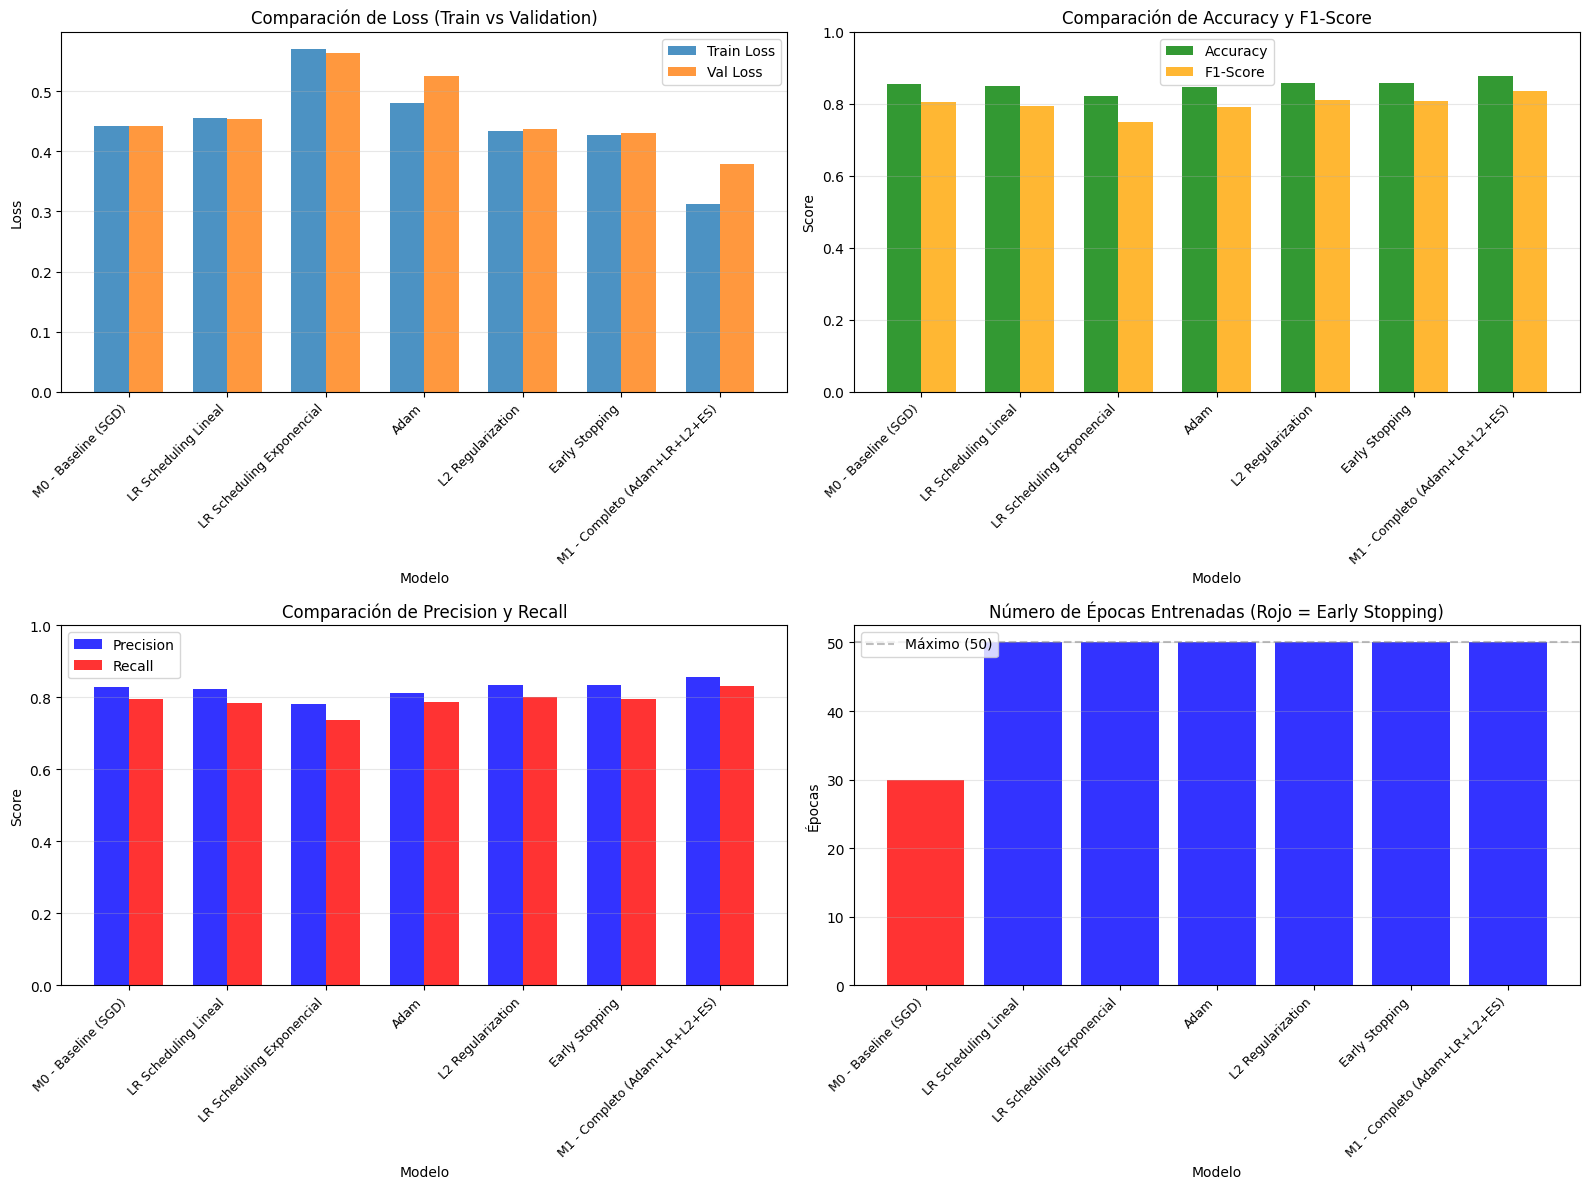


MEJORES MODELOS POR MÉTRICA
Mejor Accuracy: M1 - Completo (Adam+LR+L2+ES) (0.8770)
Mejor F1-Score: M1 - Completo (Adam+LR+L2+ES) (0.8365)
Menor Val Loss: M1 - Completo (Adam+LR+L2+ES) (0.3787)
Mejor Precision: M1 - Completo (Adam+LR+L2+ES) (0.8555)
Mejor Recall: M1 - Completo (Adam+LR+L2+ES) (0.8308)


In [21]:
# Visualización gráfica de la comparación de modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convertir columnas numéricas de string a float para graficar
metrics_df_plot = metrics_df.copy()
for col in ['Train Loss', 'Val Loss', 'Accuracy', 'F1-Score', 'Precision', 'Recall']:
    metrics_df_plot[col] = metrics_df_plot[col].astype(float)

# 1. Comparación de Losses
ax = axes[0, 0]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Train Loss'], width, label='Train Loss', alpha=0.8)
ax.bar(x + width/2, metrics_df_plot['Val Loss'], width, label='Val Loss', alpha=0.8)
ax.set_xlabel('Modelo')
ax.set_ylabel('Loss')
ax.set_title('Comparación de Loss (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Comparación de Accuracy y F1-Score
ax = axes[0, 1]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Accuracy'], width, label='Accuracy', alpha=0.8, color='green')
ax.bar(x + width/2, metrics_df_plot['F1-Score'], width, label='F1-Score', alpha=0.8, color='orange')
ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Accuracy y F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# 3. Comparación de Precision y Recall
ax = axes[1, 0]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Precision'], width, label='Precision', alpha=0.8, color='blue')
ax.bar(x + width/2, metrics_df_plot['Recall'], width, label='Recall', alpha=0.8, color='red')
ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Precision y Recall')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])



# 4. Número de épocas entrenadas
ax = axes[1, 1]
colors = ['red' if e < 50 else 'blue' for e in metrics_df_plot['Épocas']]
ax.bar(x, metrics_df_plot['Épocas'], alpha=0.8, color=colors)
ax.set_xlabel('Modelo')
ax.set_ylabel('Épocas')
ax.set_title('Número de Épocas Entrenadas (Rojo = Early Stopping)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Máximo (50)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar el mejor modelo según diferentes métricas
print("\n" + "="*100)
print("MEJORES MODELOS POR MÉTRICA")
print("="*100)
print(f"Mejor Accuracy: {metrics_df_plot.loc[metrics_df_plot['Accuracy'].idxmax(), 'Modelo']} ({metrics_df_plot['Accuracy'].max():.4f})")
print(f"Mejor F1-Score: {metrics_df_plot.loc[metrics_df_plot['F1-Score'].idxmax(), 'Modelo']} ({metrics_df_plot['F1-Score'].max():.4f})")
print(f"Menor Val Loss: {metrics_df_plot.loc[metrics_df_plot['Val Loss'].idxmin(), 'Modelo']} ({metrics_df_plot['Val Loss'].min():.4f})")
print(f"Mejor Precision: {metrics_df_plot.loc[metrics_df_plot['Precision'].idxmax(), 'Modelo']} ({metrics_df_plot['Precision'].max():.4f})")
print(f"Mejor Recall: {metrics_df_plot.loc[metrics_df_plot['Recall'].idxmax(), 'Modelo']} ({metrics_df_plot['Recall'].max():.4f})")
print("="*100)

### B

veo unicamente con el modelo comleto y vario un h a la vez

In [22]:
import time
import cupy as cp
import numpy as np
import pandas as pd # Para mostrar resultados fácilmente

# --- Configuración Base y Listas de Parámetros a Probar ---
BASE_LR = 0.01           # Learning rate inicial fijo para esta exploración
BATCH_SIZE_EXP = 256     # Tamaño de batch fijo
EPOCHS_EXPLORE = 30      # Épocas para cada prueba (puede ser menor que 50 para acelerar)

# Parámetros a explorar (puedes ajustar estos rangos)
lambdas_to_try = [0.0001, 0.001, 0.01]
decay_rates_to_try = [0.98, 0.95, 0.90]
patiences_to_try = [10, 20, 30]

# Variables para guardar los mejores hiperparámetros encontrados
best_lambda = None
best_decay_rate = None
best_patience = None

# Lista para guardar todos los resultados de la exploración
m1_hyper_results = []

# --- 1. Exploración de Lambda (L2 Regularization) ---
print("\n" + "="*80)
print(" PASO 1: Explorando Lambda (L2 Regularization)")
print(" Fijando: LR_schedule=exp, decay_rate=0.95, patience=20")
print("="*80)

overall_best_val_loss = float('inf')
results_step1 = []

# Parámetros fijos para este paso
fixed_decay_rate = 0.95
fixed_patience = 20

for current_lambda in lambdas_to_try:
    print(f"\n--- Probando Lambda = {current_lambda} ---")
    model_step1 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
    
    start_time_step = time.time()
    history_step1 = model_step1.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': fixed_decay_rate},
                                      lambda_reg=current_lambda, # VARIACIÓN
                                      early_stopping_patience=fixed_patience, 
                                      verbose=True) # Menos output durante exploración
    end_time_step = time.time()
    
    min_val_loss = min(history_step1['val_loss']) if history_step1['val_loss'] else float('inf')
    epochs_run = len(history_step1['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step1.append({
        'lambda_reg': current_lambda, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_lambda = current_lambda
        print(f"  ✨ Nuevo mejor Lambda encontrado!")

print("\n" + "-"*40)
print("Resultados Exploración Lambda:")
results_df_step1 = pd.DataFrame(results_step1)
print(results_df_step1.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Lambda seleccionado: {best_lambda} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step1) # Guardar resultados globales

# Limpieza de memoria (opcional, descomentar si hay problemas)
del model_step1, history_step1
cp.get_default_memory_pool().free_all_blocks()

# --- 2. Exploración de Decay Rate (LR Schedule) ---
print("\n" + "="*80)
print(" PASO 2: Explorando Decay Rate (LR Schedule)")
print(f" Usando: best_lambda={best_lambda}")
print(" Fijando: patience=20")
print("="*80)

overall_best_val_loss = float('inf') # Reiniciar para este paso
results_step2 = []

for current_decay_rate in decay_rates_to_try:
    print(f"\n--- Probando Decay Rate = {current_decay_rate} ---")
    model_step2 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
                      
    start_time_step = time.time()
    history_step2 = model_step2.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': current_decay_rate}, # VARIACIÓN
                                      lambda_reg=best_lambda, # Usar el mejor lambda
                                      early_stopping_patience=fixed_patience, 
                                      verbose=True) 
    end_time_step = time.time()

    min_val_loss = min(history_step2['val_loss']) if history_step2['val_loss'] else float('inf')
    epochs_run = len(history_step2['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step2.append({
        'decay_rate': current_decay_rate, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken,
        'lambda_used': best_lambda # Documentar qué lambda se usó
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_decay_rate = current_decay_rate
        print(f"  ✨ Nuevo mejor Decay Rate encontrado!")

print("\n" + "-"*40)
print("Resultados Exploración Decay Rate:")
results_df_step2 = pd.DataFrame(results_step2)
print(results_df_step2.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Decay Rate seleccionado: {best_decay_rate} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step2)

# Limpieza de memoria
del model_step2, history_step2
cp.get_default_memory_pool().free_all_blocks()

# --- 3. Exploración de Patience (Early Stopping) ---
print("\n" + "="*80)
print(" PASO 3: Explorando Patience (Early Stopping)")
print(f" Usando: best_lambda={best_lambda}, best_decay_rate={best_decay_rate}")
print("="*80)

overall_best_val_loss = float('inf') # Reiniciar para este paso
results_step3 = []

for current_patience in patiences_to_try:
    print(f"\n--- Probando Patience = {current_patience} ---")
    model_step3 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
                      
    start_time_step = time.time()
    history_step3 = model_step3.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': best_decay_rate}, # Usar el mejor decay
                                      lambda_reg=best_lambda, # Usar el mejor lambda
                                      early_stopping_patience=current_patience, # VARIACIÓN
                                      verbose=True)
    end_time_step = time.time()

    min_val_loss = min(history_step3['val_loss']) if history_step3['val_loss'] else float('inf')
    epochs_run = len(history_step3['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step3.append({
        'patience': current_patience, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken,
        'lambda_used': best_lambda,
        'decay_rate_used': best_decay_rate
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_patience = current_patience
        print(f"  ✨ Nueva mejor Patience encontrada!")

print("\n" + "-"*40)
print("Resultados Exploración Patience:")
results_df_step3 = pd.DataFrame(results_step3)
print(results_df_step3.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Patience seleccionada: {best_patience} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step3)

# Limpieza de memoria
del model_step3, history_step3
cp.get_default_memory_pool().free_all_blocks()




 PASO 1: Explorando Lambda (L2 Regularization)
 Fijando: LR_schedule=exp, decay_rate=0.95, patience=20

--- Probando Lambda = 0.0001 ---
Epoch 0/30 - LR: 0.010000 - Train Loss: 0.6671 - Val Loss: 0.5447
Epoch 10/30 - LR: 0.005987 - Train Loss: 0.4167 - Val Loss: 0.4355
Epoch 20/30 - LR: 0.003585 - Train Loss: 0.3625 - Val Loss: 0.4071

Training completed. Best validation loss: 0.3944

TRAINING TIME SUMMARY
Total time: 304.48s (5.07 min)
Epochs trained: 30
Time per epoch: 10.15s

  Resultado: Min Val Loss=0.3944 (30 épocas, 304.5s)
  ✨ Nuevo mejor Lambda encontrado!

--- Probando Lambda = 0.001 ---
Epoch 0/30 - LR: 0.010000 - Train Loss: 0.7104 - Val Loss: 0.5705
Epoch 10/30 - LR: 0.005987 - Train Loss: 0.4525 - Val Loss: 0.4613
Epoch 20/30 - LR: 0.003585 - Train Loss: 0.3977 - Val Loss: 0.4188

Training completed. Best validation loss: 0.4000

TRAINING TIME SUMMARY
Total time: 302.17s (5.04 min)
Epochs trained: 30
Time per epoch: 10.07s

  Resultado: Min Val Loss=0.4000 (30 épocas, 30

In [23]:
# --- 4. Entrenamiento Final de M1 con los Mejores Hiperparámetros ---
print("\n" + "="*80)
print(" PASO 4: Entrenando M1 Final con los Mejores Hiperparámetros")
print(f" Lambda={best_lambda}, Decay Rate={best_decay_rate}, Patience={best_patience}")
print(" Entrenando por más épocas (ej: 50) con Early Stopping")
print("="*80)

FINAL_EPOCHS = 50 # Definir épocas máximas para el entrenamiento final

model_m1_final = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                     batch_size=BATCH_SIZE_EXP, optimizer='adam')
                     
start_time_final = time.time()
history_m1_final = model_m1_final.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                        epochs=FINAL_EPOCHS, 
                                        learning_rate=BASE_LR,
                                        lr_schedule='exponential', lr_schedule_params={'decay_rate': best_decay_rate},
                                        lambda_reg=best_lambda,
                                        early_stopping_patience=best_patience, 
                                        verbose=True) # Mostrar output del entrenamiento final
end_time_final = time.time()

final_min_val_loss = min(history_m1_final['val_loss']) if history_m1_final['val_loss'] else float('inf')
final_epochs_run = len(history_m1_final['train_loss'])
final_time_taken = end_time_final - start_time_final

print(f"\n--- Entrenamiento Final M1 Completado ---")
print(f"  Mejor Val Loss: {final_min_val_loss:.4f}")
print(f"  Épocas corridas: {final_epochs_run} / {FINAL_EPOCHS}")
print(f"  Tiempo total: {final_time_taken:.1f}s ({final_time_taken/60:.2f} min)")

# Guardar el modelo y su historial final para usar en las siguientes secciones
# (Puedes renombrar las variables si prefieres mantener las originales `model_m1` y `history_m1`)
model_m1 = model_m1_final 
history_m1 = history_m1_final 




 PASO 4: Entrenando M1 Final con los Mejores Hiperparámetros
 Lambda=0.01, Decay Rate=0.9, Patience=30
 Entrenando por más épocas (ej: 50) con Early Stopping
Epoch 0/50 - LR: 0.010000 - Train Loss: 0.7242 - Val Loss: 0.6041
Epoch 10/50 - LR: 0.003487 - Train Loss: 0.4250 - Val Loss: 0.4463
Epoch 20/50 - LR: 0.001216 - Train Loss: 0.3592 - Val Loss: 0.3834
Epoch 30/50 - LR: 0.000424 - Train Loss: 0.3307 - Val Loss: 0.3621
Epoch 40/50 - LR: 0.000148 - Train Loss: 0.3190 - Val Loss: 0.3586

Training completed. Best validation loss: 0.3577

TRAINING TIME SUMMARY
Total time: 502.03s (8.37 min)
Epochs trained: 50
Time per epoch: 10.04s


--- Entrenamiento Final M1 Completado ---
  Mejor Val Loss: 0.3577
  Épocas corridas: 50 / 50
  Tiempo total: 502.0s (8.37 min)


FALTA VARIAR LAS ARQUITECTURAS

## 3.b) Exploración de Arquitecturas para M1

Probar diferentes arquitecturas para encontrar la configuración óptima

In [24]:
print("="*80)
print("EXPLORACIÓN DE ARQUITECTURAS - Sección 3.b")
print("="*80)
print("Buscando mejor arquitectura con hiperparámetros optimizados de M1\n")
print(f"Usando hiperparámetros encontrados en experimentos previos:")
print(f"  - Lambda (L2): {best_lambda}")
print(f"  - Decay Rate: {best_decay_rate}")
print(f"  - Patience: {best_patience}")
print(f"  - Learning Rate: 0.001 (Adam optimizado)")
print(f"  - Batch Size: 128\n")

architectures_to_test = [
    ([256, 128], "Arch_1: [256, 128]"),
    ([512, 256, 128], "Arch_2: [512, 256, 128]"),
    ([128, 128], "Arch_3: [128, 128]"),
    ([64, 64, 64], "Arch_4: [64, 64, 64]"),
    ([256, 128, 64], "Arch_5: [256, 128, 64]")
]

arch_results = []
ARCH_LR = 0.001
ARCH_DECAY = best_decay_rate
ARCH_LAMBDA = best_lambda
ARCH_PATIENCE = best_patience
ARCH_BATCH = 128

for arch, arch_name in architectures_to_test:
    print(f"\n{'='*80}")
    print(f"Entrenando: {arch_name}")
    print(f"{'='*80}")
    
    layer_sizes_arch = [784] + arch + [47]
    model_arch = MLP(n_layers=len(arch)+1, layer_sizes=layer_sizes_arch, 
                     batch_size=ARCH_BATCH, optimizer='adam')
    
    history_arch = model_arch.train(
        X_train_T, y_train_onehot, X_val_T, y_val_onehot,
        epochs=50, learning_rate=ARCH_LR,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': ARCH_DECAY},
        lambda_reg=ARCH_LAMBDA,
        early_stopping_patience=ARCH_PATIENCE,
        verbose=True
    )
    
    y_pred_arch = model_arch.predict(cp.asarray(X_val_T))
    y_pred_arch_cpu = cp.asnumpy(y_pred_arch)
    acc_arch = accuracy(y_val, y_pred_arch_cpu)
    
    arch_results.append({
        'Arquitectura': arch_name,
        'Capas': str(arch),
        'Val Loss': f"{history_arch['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_arch:.4f}",
        'Épocas': len(history_arch['train_loss'])
    })

arch_df = pd.DataFrame(arch_results)
print("\n" + "="*80)
print("COMPARACIÓN DE ARQUITECTURAS")
print("="*80)
print(arch_df.to_string(index=False))
print("="*80)

best_arch_idx = arch_df['Accuracy'].astype(float).idxmax()
print(f"\n✓ Mejor arquitectura: {arch_df.loc[best_arch_idx, 'Arquitectura']}")
print(f"  Accuracy: {arch_df.loc[best_arch_idx, 'Accuracy']}")
print(f"  Val Loss: {arch_df.loc[best_arch_idx, 'Val Loss']}")

EXPLORACIÓN DE ARQUITECTURAS - Sección 3.b
Buscando mejor arquitectura con hiperparámetros optimizados de M1

Usando hiperparámetros encontrados en experimentos previos:
  - Lambda (L2): 0.01
  - Decay Rate: 0.9
  - Patience: 30
  - Learning Rate: 0.001 (Adam optimizado)
  - Batch Size: 128


Entrenando: Arch_1: [256, 128]
Epoch 0/50 - LR: 0.001000 - Train Loss: 0.7159 - Val Loss: 0.4946
Epoch 10/50 - LR: 0.000349 - Train Loss: 0.3373 - Val Loss: 0.3641
Epoch 20/50 - LR: 0.000122 - Train Loss: 0.3074 - Val Loss: 0.3531
Epoch 30/50 - LR: 0.000042 - Train Loss: 0.2962 - Val Loss: 0.3522
Epoch 40/50 - LR: 0.000015 - Train Loss: 0.2919 - Val Loss: 0.3512

Training completed. Best validation loss: 0.3511

TRAINING TIME SUMMARY
Total time: 955.93s (15.93 min)
Epochs trained: 50
Time per epoch: 19.12s


Entrenando: Arch_2: [512, 256, 128]
Epoch 0/50 - LR: 0.001000 - Train Loss: 0.7160 - Val Loss: 0.4654
Epoch 10/50 - LR: 0.000349 - Train Loss: 0.3137 - Val Loss: 0.3520
Epoch 20/50 - LR: 0.000

# 4. Desarrollo de una Red Neuronal con PyTorch


In [25]:
# ============================================================================
# MODELO M2 - PyTorch Implementation
# ============================================================================

# CRÍTICO: Liberar TODA la memoria antes de empezar con PyTorch
print("="*80)
print("PREPARACIÓN PARA MODELO M2 (PyTorch)")
print("="*80)
print("\n🧹 LIMPIEZA COMPLETA DE MEMORIA GPU")
print("⚠️  Eliminando referencias a modelos anteriores...")

# Eliminar modelo M1 de CuPy si existe
try:
    del mlp, model_m1  # Eliminar referencias a M1
    print("✓ Modelo M1 (CuPy) eliminado de memoria")
except:
    pass



PREPARACIÓN PARA MODELO M2 (PyTorch)

🧹 LIMPIEZA COMPLETA DE MEMORIA GPU
⚠️  Eliminando referencias a modelos anteriores...
✓ Modelo M1 (CuPy) eliminado de memoria


## Utilidades para Manejo de Memoria GPU (4GB VRAM)

**IMPORTANTE:** Con solo 4GB de VRAM necesitamos gestionar la memoria cuidadosamente para evitar errores OOM.

In [26]:
# ============================================================================
# UTILIDADES PARA MANEJO DE MEMORIA GPU (4GB VRAM)
# ============================================================================

import gc
import torch

def clear_gpu_memory():
    """Libera memoria de GPU (CuPy y PyTorch)"""
    gc.collect()
    
    # Limpiar CuPy
    try:
        import cupy as cp
        cp.get_default_memory_pool().free_all_blocks()
    except:
        pass
    
    # Limpiar PyTorch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def print_gpu_memory():
    """Muestra el uso actual de memoria GPU"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        reserved = torch.cuda.memory_reserved(0) / (1024**3)
        total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"GPU Memory - Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB | Total: {total:.2f} GB")
    else:
        print("CUDA no disponible")

print("✓ Funciones de manejo de memoria GPU cargadas\n")
print("="*80)
print("RECOMENDACIONES PARA 4GB DE VRAM")
print("="*80)
print("⚠️  Para evitar errores OOM (Out Of Memory):")
print("   1. Usar batch_size pequeño (32-128) según complejidad del modelo")
print("   2. Liberar memoria entre experimentos con clear_gpu_memory()")
print("   3. Entrenar modelos secuencialmente, no todos a la vez")
print("   4. Monitorear uso con print_gpu_memory()")
print("   5. SIEMPRE llamar clear_gpu_memory() antes de entrenar un nuevo modelo")
print("="*80)

# Limpiar memoria inicial
print("\nLimpiando memoria GPU...")
clear_gpu_memory()
print("\nEstado inicial de la GPU:")
print_gpu_memory()

✓ Funciones de manejo de memoria GPU cargadas

RECOMENDACIONES PARA 4GB DE VRAM
⚠️  Para evitar errores OOM (Out Of Memory):
   1. Usar batch_size pequeño (32-128) según complejidad del modelo
   2. Liberar memoria entre experimentos con clear_gpu_memory()
   3. Entrenar modelos secuencialmente, no todos a la vez
   4. Monitorear uso con print_gpu_memory()
   5. SIEMPRE llamar clear_gpu_memory() antes de entrenar un nuevo modelo

Limpiando memoria GPU...

Estado inicial de la GPU:
GPU Memory - Allocated: 0.00 GB | Reserved: 0.00 GB | Total: 14.74 GB


In [27]:
from models import *



print("\n" + "="*80)
print("CONFIGURACIÓN DEL MODELO M2 (PyTorch)")
print("="*80)

# IMPORTANTE: Liberar memoria agresivamente antes de crear el modelo
print("\n⚠️  Liberando memoria GPU AGRESIVAMENTE antes de crear M2...")
clear_gpu_memory()
print_gpu_memory()
print()

# Crear modelo con la misma arquitectura que M1
input_size_pt = 784
hidden_sizes_pt = [128, 64]
num_classes_pt = 47

print(f"\nArquitectura:")
print(f"  Input: {input_size_pt}")
print(f"  Hidden: {hidden_sizes_pt}")
print(f"  Output: {num_classes_pt}")

# Instanciar modelo y trainer
model_m2 = MLP_PyTorch(input_size=input_size_pt, 
                       hidden_sizes=hidden_sizes_pt, 
                       num_classes=num_classes_pt)

trainer_m2 = PyTorchTrainer(model_m2)

print(f"\n✓ Modelo M2 creado exitosamente")
print(f"Parámetros totales: {sum(p.numel() for p in model_m2.parameters()):,}")

# Preparar datos (crear DataLoaders)
# CRÍTICO: Batch size MUY REDUCIDO para 4GB VRAM
print(f"\n📦 Preparando datos para PyTorch...")
print(f"⚠️  Usando batch_size=64 (reducido para evitar OOM con 4GB VRAM)")

train_loader, val_loader = trainer_m2.prepare_data(
    X_train_flat, y_train, 
    X_val_flat, y_val, 
    batch_size=256  # CRÍTICO: Reducido de 128 a 64 para evitar OOM
)

print(f"✓ DataLoaders creados")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Batch size: 64")

print("\n💾 Memoria GPU después de preparar datos:")
print_gpu_memory()

# Liberar memoria nuevamente
clear_gpu_memory()
print("\n💾 Memoria GPU después de limpieza:")
print_gpu_memory()


CONFIGURACIÓN DEL MODELO M2 (PyTorch)

⚠️  Liberando memoria GPU AGRESIVAMENTE antes de crear M2...
GPU Memory - Allocated: 0.00 GB | Reserved: 0.00 GB | Total: 14.74 GB


Arquitectura:
  Input: 784
  Hidden: [128, 64]
  Output: 47

✓ Modelo M2 creado exitosamente
Parámetros totales: 111,791

📦 Preparando datos para PyTorch...
⚠️  Usando batch_size=64 (reducido para evitar OOM con 4GB VRAM)
✓ DataLoaders creados
  - Train batches: 2214
  - Val batches: 475
  - Batch size: 64

💾 Memoria GPU después de preparar datos:
GPU Memory - Allocated: 0.00 GB | Reserved: 0.00 GB | Total: 14.74 GB

💾 Memoria GPU después de limpieza:
GPU Memory - Allocated: 0.00 GB | Reserved: 0.00 GB | Total: 14.74 GB


In [28]:
print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO M2 (PyTorch)")
print("="*80)
print("Configuración: Adam + LR Exponential + L2 + Early Stopping")
print("(Mismos hiperparámetros que M1 para comparación justa)")
print("="*80 + "\n")

# Entrenar con los mismos hiperparámetros que M1
history_m2 = trainer_m2.train(
    train_loader, 
    val_loader,
    epochs=50,
    learning_rate=0.001,          # Mismo que M1
    weight_decay=0.001,            # Lambda reg = 0.001 (mismo que M1)
    lr_schedule='exponential',
    lr_schedule_params={'decay_rate': 0.95},  # Mismo que M1
    early_stopping_patience=20,    # Mismo que M1
    verbose=True
)


ENTRENAMIENTO DEL MODELO M2 (PyTorch)
Configuración: Adam + LR Exponential + L2 + Early Stopping
(Mismos hiperparámetros que M1 para comparación justa)

Epoch [1/50], LR: 0.001000, Train Loss: 0.8364, Train Acc: 0.7559, Val Loss: 0.5747, Val Acc: 0.8214
Epoch [11/50], LR: 0.000599, Train Loss: 0.4168, Train Acc: 0.8628, Val Loss: 0.4125, Val Acc: 0.8637
Epoch [21/50], LR: 0.000358, Train Loss: 0.3972, Train Acc: 0.8691, Val Loss: 0.3929, Val Acc: 0.8702
Epoch [31/50], LR: 0.000215, Train Loss: 0.3868, Train Acc: 0.8730, Val Loss: 0.3867, Val Acc: 0.8726
Epoch [41/50], LR: 0.000129, Train Loss: 0.3813, Train Acc: 0.8748, Val Loss: 0.3824, Val Acc: 0.8741

Training completed. Best validation loss: 0.3797

TRAINING TIME SUMMARY
Total time: 7min 51s (471.91s)
Epochs trained: 50
Time per epoch: 9.44s



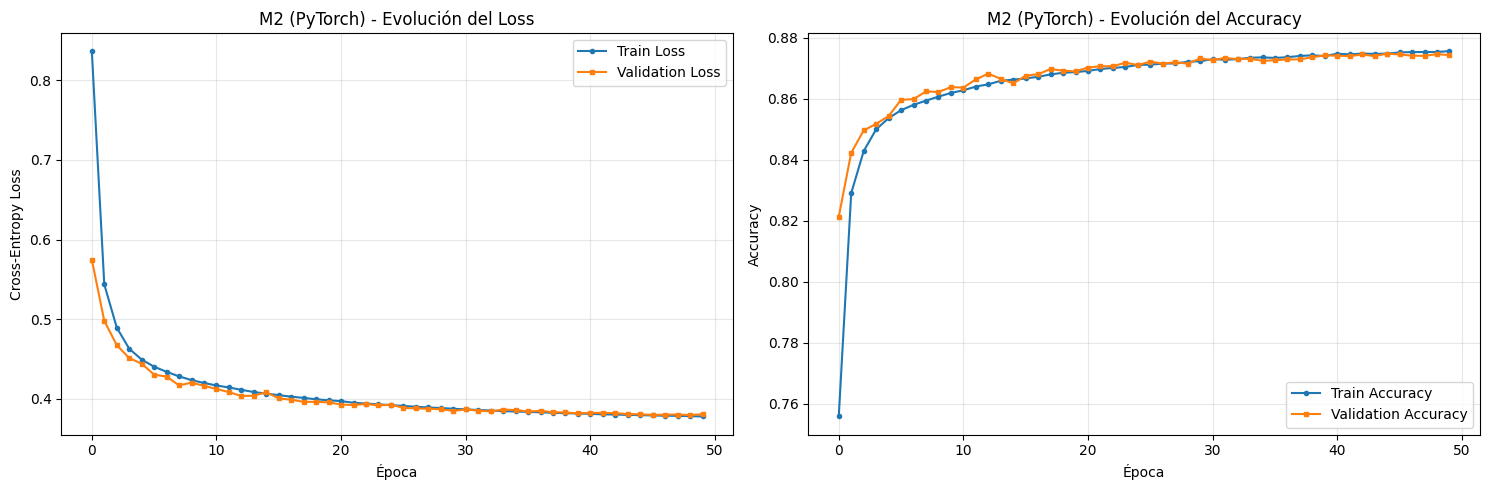


ANÁLISIS DE CONVERGENCIA - M2
Mejor Val Loss: 0.3797 en época 49
Loss final - Train: 0.3779, Val: 0.3807
Accuracy final - Train: 0.8756, Val: 0.8743
Gap Train-Val Loss: 0.0028


In [29]:
# Visualizar curvas de entrenamiento de M2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_m2['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history_m2['val_loss'], label='Validation Loss', marker='s', markersize=3)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('M2 (PyTorch) - Evolución del Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_m2['train_acc'], label='Train Accuracy', marker='o', markersize=3)
axes[1].plot(history_m2['val_acc'], label='Validation Accuracy', marker='s', markersize=3)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('M2 (PyTorch) - Evolución del Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de convergencia
print("\n" + "="*80)
print("ANÁLISIS DE CONVERGENCIA - M2")
print("="*80)
best_epoch = np.argmin(history_m2['val_loss'])
print(f"Mejor Val Loss: {history_m2['val_loss'][best_epoch]:.4f} en época {best_epoch+1}")
print(f"Loss final - Train: {history_m2['train_loss'][-1]:.4f}, Val: {history_m2['val_loss'][-1]:.4f}")
print(f"Accuracy final - Train: {history_m2['train_acc'][-1]:.4f}, Val: {history_m2['val_acc'][-1]:.4f}")
print(f"Gap Train-Val Loss: {abs(history_m2['train_loss'][-1] - history_m2['val_loss'][-1]):.4f}")
print("="*80)


EVALUACIÓN DEL MODELO M2 EN CONJUNTO DE VALIDACIÓN

=== Métricas en Validación (VAL) para M2 ===
metricas
Accuracy: 0.8746 (87.46%)
F1-Score Macro: 0.8322
Precision promedio: 0.8623
Recall promedio: 0.8219


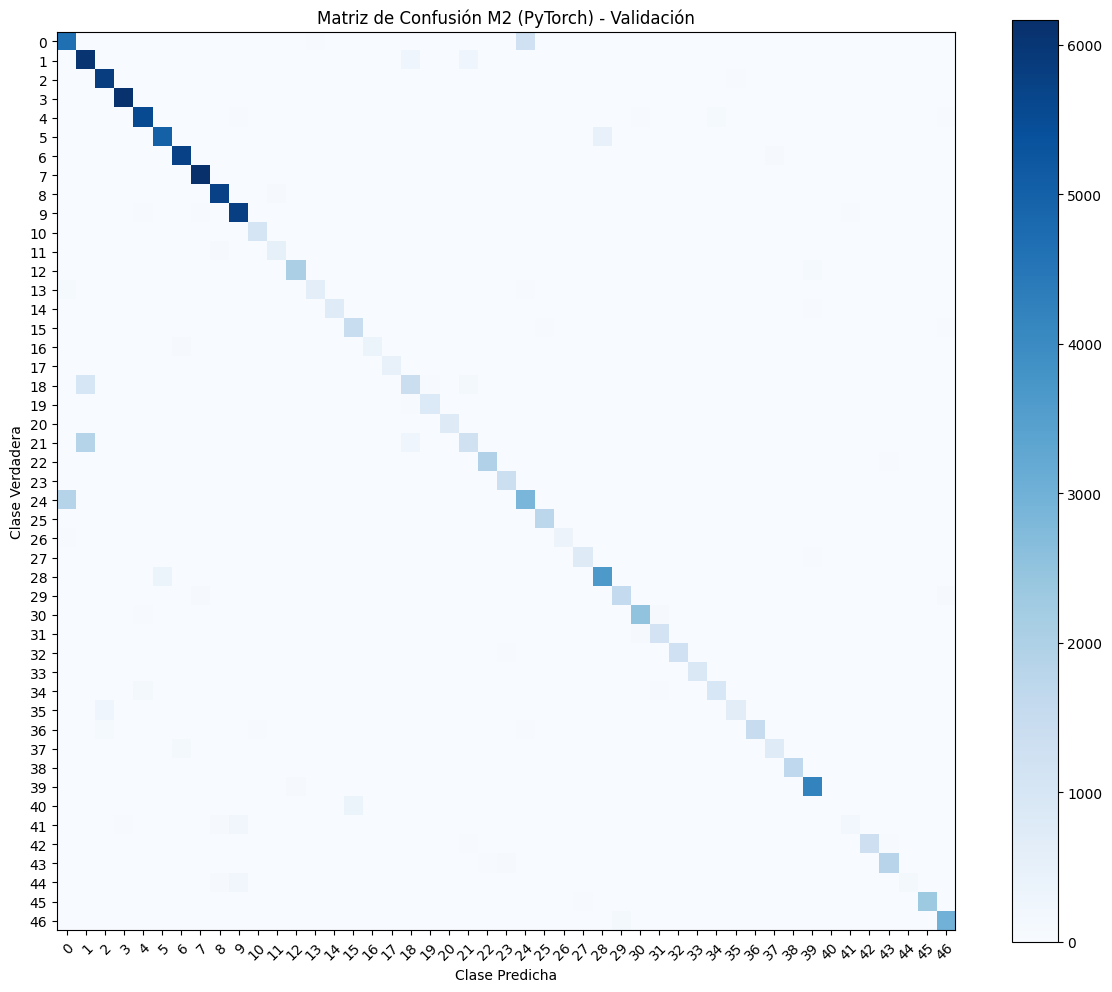

In [30]:
print("\n" + "="*80)
print("EVALUACIÓN DEL MODELO M2 EN CONJUNTO DE VALIDACIÓN")
print("="*80 + "\n")

# Hacer predicciones en validación
y_pred_m2_val = trainer_m2.predict(X_val_flat)

# Calcular métricas usando nuestras funciones de metrics.py
print("=== Métricas en Validación (VAL) para M2 ===")
metrics_M2_val = evaluate_model(y_val, y_pred_m2_val, n_classes=num_classes_pt, verbose=True)

# Agregar loss para comparación
metrics_M2_val['val_loss'] = history_m2['val_loss'][-1]

# Matriz de confusión
plot_confusion_matrix(
    metrics_M2_val['confusion_matrix'], 
    title='Matriz de Confusión M2 (PyTorch) - Validación'
)
plt.show()

In [31]:
print("\n" + "="*100)
print("COMPARACIÓN FINAL: M1 (Custom CuPy) vs M2 (PyTorch)")
print("="*100)

# Obtener métricas de M1 (desde la tabla anterior)
metrics_M1_row = metrics_df[metrics_df['Modelo'] == 'M1 - Completo (Adam+LR+L2+ES)'].iloc[0]

# Crear tabla comparativa
comparison_data = {
    'Métrica': [
        'Validation Loss',
        'Accuracy', 
        'F1-Score Macro',
        'Precision Promedio',
        'Recall Promedio',
        'Tiempo Total (min)',
        'Tiempo por Época (s)'
    ],
    'M1 (Custom CuPy)': [
        float(metrics_M1_row['Val Loss']),
        float(metrics_M1_row['Accuracy']),
        float(metrics_M1_row['F1-Score']),
        float(metrics_M1_row['Precision']),
        float(metrics_M1_row['Recall']),
        history_m1_final['training_time']['total_minutes'],
        history_m1_final['training_time']['seconds_per_epoch']
    ],
    'M2 (PyTorch)': [
        metrics_M2_val['val_loss'],
        metrics_M2_val['accuracy'],
        metrics_M2_val['f1_macro'],
        np.mean(metrics_M2_val['precision_per_class']),
        np.mean(metrics_M2_val['recall_per_class']),
        history_m2['training_time']['total_minutes'],
        history_m2['training_time']['seconds_per_epoch']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))
print("="*100)

# Análisis de diferencias
print("\n=== Análisis de Diferencias ===")
diff_acc = abs(comparison_df.loc[1, 'M1 (Custom CuPy)'] - comparison_df.loc[1, 'M2 (PyTorch)'])
diff_loss = abs(comparison_df.loc[0, 'M1 (Custom CuPy)'] - comparison_df.loc[0, 'M2 (PyTorch)'])
diff_f1 = abs(comparison_df.loc[2, 'M1 (Custom CuPy)'] - comparison_df.loc[2, 'M2 (PyTorch)'])
diff_time = abs(comparison_df.loc[5, 'M1 (Custom CuPy)'] - comparison_df.loc[5, 'M2 (PyTorch)'])

print(f"Diferencia en Accuracy: {diff_acc:.4f} ({diff_acc*100:.2f}%)")
print(f"Diferencia en Val Loss: {diff_loss:.4f}")
print(f"Diferencia en F1-Score: {diff_f1:.4f}")
print(f"Diferencia en Tiempo: {diff_time:.2f} min")

# Validación
if diff_acc < 0.02 and diff_loss < 0.1:
    print("\n✓ Validación exitosa: M1 y M2 tienen rendimiento similar.")
    print("  La implementación custom con CuPy es equivalente a PyTorch.")
else:
    print("\n⚠️ Advertencia: M1 y M2 difieren significativamente.")
    print("  Revisar hiperparámetros o implementaciones.")

# Identificar el mejor modelo
if comparison_df.loc[1, 'M2 (PyTorch)'] > comparison_df.loc[1, 'M1 (Custom CuPy)']:
    best_model = "M2 (PyTorch)"
    best_acc = comparison_df.loc[1, 'M2 (PyTorch)']
else:
    best_model = "M1 (Custom CuPy)"
    best_acc = comparison_df.loc[1, 'M1 (Custom CuPy)']

print(f"\n🏆 Mejor modelo: {best_model} con Accuracy = {best_acc:.4f}")
print("="*100)


COMPARACIÓN FINAL: M1 (Custom CuPy) vs M2 (PyTorch)

             Métrica  M1 (Custom CuPy)  M2 (PyTorch)
     Validation Loss          0.378700      0.380725
            Accuracy          0.877000      0.874614
      F1-Score Macro          0.836500      0.832223
  Precision Promedio          0.855500      0.862291
     Recall Promedio          0.830800      0.821873
  Tiempo Total (min)          8.367230      7.865234
Tiempo por Época (s)         10.040676      9.438281

=== Análisis de Diferencias ===
Diferencia en Accuracy: 0.0024 (0.24%)
Diferencia en Val Loss: 0.0020
Diferencia en F1-Score: 0.0043
Diferencia en Tiempo: 0.50 min

✓ Validación exitosa: M1 y M2 tienen rendimiento similar.
  La implementación custom con CuPy es equivalente a PyTorch.

🏆 Mejor modelo: M1 (Custom CuPy) con Accuracy = 0.8770



## 4.b) Exploración con Arquitecturas Avanzadas (M3)

Explorar arquitecturas, activaciones modernas y dropout con PyTorch

In [32]:
print("="*80)
print("M3 - EXPERIMENTACIÓN CON ARQUITECTURAS PYTORCH")
print("="*80)

m3_architectures = [
    ([256, 128], "M3_Arch_1: [256, 128]"),
    ([512, 256], "M3_Arch_2: [512, 256]"),
    ([128, 128, 64], "M3_Arch_3: [128, 128, 64]"),
    ([256, 256, 128], "M3_Arch_4: [256, 256, 128]")
]

m3_arch_results = []

for hidden_arch, arch_name in m3_architectures:
    print(f"\n{'='*80}")
    print(f"Entrenando: {arch_name}")
    print(f"{'='*80}")
    
    model_m3_arch = MLP_PyTorch_Advanced(
        input_size=784, 
        hidden_sizes=hidden_arch,
        num_classes=47,
        activation='relu',
        dropout_rate=0.0
    )
    
    trainer_m3_arch = PyTorchTrainer(model_m3_arch, device='cuda')
    train_loader_m3, val_loader_m3 = trainer_m3_arch.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_arch = trainer_m3_arch.train(
        train_loader_m3, val_loader_m3,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_arch = trainer_m3_arch.predict(X_val_flat)
    acc_m3_arch = accuracy(y_val, y_pred_m3_arch)
    
    m3_arch_results.append({
        'Arquitectura': arch_name,
        'Capas': str(hidden_arch),
        'Val Loss': f"{history_m3_arch['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_arch:.4f}",
        'Épocas': len(history_m3_arch['train_loss'])
    })

m3_arch_df = pd.DataFrame(m3_arch_results)
print("\n" + "="*80)
print("COMPARACIÓN ARQUITECTURAS M3")
print("="*80)
print(m3_arch_df.to_string(index=False))
print("="*80)

M3 - EXPERIMENTACIÓN CON ARQUITECTURAS PYTORCH

Entrenando: M3_Arch_1: [256, 128]
Epoch [1/50], LR: 0.001000, Train Loss: 0.6564, Train Acc: 0.7983, Val Loss: 0.4777, Val Acc: 0.8438
Epoch [11/50], LR: 0.000599, Train Loss: 0.4000, Train Acc: 0.8664, Val Loss: 0.4003, Val Acc: 0.8667
Epoch [21/50], LR: 0.000358, Train Loss: 0.3832, Train Acc: 0.8723, Val Loss: 0.3808, Val Acc: 0.8735
Epoch [31/50], LR: 0.000215, Train Loss: 0.3733, Train Acc: 0.8761, Val Loss: 0.3692, Val Acc: 0.8760
Epoch [41/50], LR: 0.000129, Train Loss: 0.3670, Train Acc: 0.8784, Val Loss: 0.3664, Val Acc: 0.8778

Training completed. Best validation loss: 0.3647

TRAINING TIME SUMMARY
Total time: 11min 6s (666.48s)
Epochs trained: 50
Time per epoch: 13.33s


Entrenando: M3_Arch_2: [512, 256]
Epoch [1/50], LR: 0.001000, Train Loss: 0.6008, Train Acc: 0.8109, Val Loss: 0.4444, Val Acc: 0.8550
Epoch [11/50], LR: 0.000599, Train Loss: 0.3951, Train Acc: 0.8682, Val Loss: 0.3958, Val Acc: 0.8689
Epoch [21/50], LR: 0.000

In [33]:
best_arch_idx = m3_arch_df['Accuracy'].astype(float).idxmax()
BEST_M3_ARCH = m3_architectures[best_arch_idx][0]

print(f"\n{'='*80}")
print("MEJOR ARQUITECTURA SELECCIONADA PARA M3")
print(f"{'='*80}")
print(f"Arquitectura: {BEST_M3_ARCH}")
print(f"Accuracy: {m3_arch_df.loc[best_arch_idx, 'Accuracy']}")
print(f"Val Loss: {m3_arch_df.loc[best_arch_idx, 'Val Loss']}")
print(f"{'='*80}")


MEJOR ARQUITECTURA SELECCIONADA PARA M3
Arquitectura: [256, 256, 128]
Accuracy: 0.8831
Val Loss: 0.3402


In [34]:
print("\n" + "="*80)
print("M3 - EXPERIMENTACIÓN CON FUNCIONES DE ACTIVACIÓN")
print("="*80)

activations_to_test = ['relu', 'leakyrelu', 'gelu', 'silu']
m3_activation_results = []

for activation_name in activations_to_test:
    print(f"\n{'='*80}")
    print(f"Entrenando con activación: {activation_name.upper()}")
    print(f"{'='*80}")
    
    model_m3_act = MLP_PyTorch_Advanced(
        input_size=784,
        hidden_sizes=BEST_M3_ARCH,
        num_classes=47,
        activation=activation_name,
        dropout_rate=0.0
    )
    
    trainer_m3_act = PyTorchTrainer(model_m3_act, device='cuda')
    train_loader_act, val_loader_act = trainer_m3_act.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_act = trainer_m3_act.train(
        train_loader_act, val_loader_act,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_act = trainer_m3_act.predict(X_val_flat)
    acc_m3_act = accuracy(y_val, y_pred_m3_act)
    
    m3_activation_results.append({
        'Activación': activation_name.upper(),
        'Val Loss': f"{history_m3_act['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_act:.4f}",
        'Épocas': len(history_m3_act['train_loss'])
    })

m3_act_df = pd.DataFrame(m3_activation_results)
print("\n" + "="*80)
print("COMPARACIÓN FUNCIONES DE ACTIVACIÓN M3")
print("="*80)
print(m3_act_df.to_string(index=False))
print("="*80)


M3 - EXPERIMENTACIÓN CON FUNCIONES DE ACTIVACIÓN

Entrenando con activación: RELU
Epoch [1/50], LR: 0.001000, Train Loss: 0.6383, Train Acc: 0.7994, Val Loss: 0.4776, Val Acc: 0.8411
Epoch [11/50], LR: 0.000599, Train Loss: 0.3785, Train Acc: 0.8703, Val Loss: 0.3694, Val Acc: 0.8732
Epoch [21/50], LR: 0.000358, Train Loss: 0.3591, Train Acc: 0.8764, Val Loss: 0.3576, Val Acc: 0.8775
Epoch [31/50], LR: 0.000215, Train Loss: 0.3473, Train Acc: 0.8805, Val Loss: 0.3471, Val Acc: 0.8809
Epoch [41/50], LR: 0.000129, Train Loss: 0.3394, Train Acc: 0.8832, Val Loss: 0.3427, Val Acc: 0.8824

Training completed. Best validation loss: 0.3387

TRAINING TIME SUMMARY
Total time: 11min 56s (716.73s)
Epochs trained: 50
Time per epoch: 14.33s


Entrenando con activación: LEAKYRELU
Epoch [1/50], LR: 0.001000, Train Loss: 0.6308, Train Acc: 0.8005, Val Loss: 0.4826, Val Acc: 0.8380
Epoch [11/50], LR: 0.000599, Train Loss: 0.3782, Train Acc: 0.8706, Val Loss: 0.3734, Val Acc: 0.8725
Epoch [21/50], LR: 

In [35]:
best_act_idx = m3_act_df['Accuracy'].astype(float).idxmax()
BEST_M3_ACTIVATION = activations_to_test[best_act_idx]

print(f"\n{'='*80}")
print("MEJOR ACTIVACIÓN SELECCIONADA PARA M3")
print(f"{'='*80}")
print(f"Activación: {BEST_M3_ACTIVATION.upper()}")
print(f"Accuracy: {m3_act_df.loc[best_act_idx, 'Accuracy']}")
print(f"Val Loss: {m3_act_df.loc[best_act_idx, 'Val Loss']}")
print(f"{'='*80}")


MEJOR ACTIVACIÓN SELECCIONADA PARA M3
Activación: GELU
Accuracy: 0.8850
Val Loss: 0.3368


In [36]:
print("\n" + "="*80)
print("M3 - EXPERIMENTACIÓN CON DROPOUT")
print("="*80)

dropout_rates = [0.0, 0.1, 0.2, 0.3]
m3_dropout_results = []

for dropout_rate in dropout_rates:
    print(f"\n{'='*80}")
    print(f"Entrenando con Dropout: {dropout_rate}")
    print(f"{'='*80}")
    
    model_m3_drop = MLP_PyTorch_Advanced(
        input_size=784,
        hidden_sizes=BEST_M3_ARCH,
        num_classes=47,
        activation=BEST_M3_ACTIVATION,
        dropout_rate=dropout_rate
    )
    
    trainer_m3_drop = PyTorchTrainer(model_m3_drop, device='cuda')
    train_loader_drop, val_loader_drop = trainer_m3_drop.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_drop = trainer_m3_drop.train(
        train_loader_drop, val_loader_drop,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_drop = trainer_m3_drop.predict(X_val_flat)
    acc_m3_drop = accuracy(y_val, y_pred_m3_drop)
    
    m3_dropout_results.append({
        'Dropout': f"{dropout_rate:.1f}",
        'Val Loss': f"{history_m3_drop['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_drop:.4f}",
        'Épocas': len(history_m3_drop['train_loss'])
    })

m3_drop_df = pd.DataFrame(m3_dropout_results)
print("\n" + "="*80)
print("COMPARACIÓN DROPOUT M3")
print("="*80)
print(m3_drop_df.to_string(index=False))
print("="*80)


M3 - EXPERIMENTACIÓN CON DROPOUT

Entrenando con Dropout: 0.0
Epoch [1/50], LR: 0.001000, Train Loss: 0.6217, Train Acc: 0.8029, Val Loss: 0.4432, Val Acc: 0.8515
Epoch [11/50], LR: 0.000599, Train Loss: 0.3736, Train Acc: 0.8712, Val Loss: 0.3626, Val Acc: 0.8751
Epoch [21/50], LR: 0.000358, Train Loss: 0.3560, Train Acc: 0.8771, Val Loss: 0.3519, Val Acc: 0.8794
Epoch [31/50], LR: 0.000215, Train Loss: 0.3458, Train Acc: 0.8805, Val Loss: 0.3454, Val Acc: 0.8809
Epoch [41/50], LR: 0.000129, Train Loss: 0.3387, Train Acc: 0.8830, Val Loss: 0.3405, Val Acc: 0.8828

Training completed. Best validation loss: 0.3364

TRAINING TIME SUMMARY
Total time: 11min 35s (695.46s)
Epochs trained: 50
Time per epoch: 13.91s


Entrenando con Dropout: 0.1
Epoch [1/50], LR: 0.001000, Train Loss: 0.6811, Train Acc: 0.7858, Val Loss: 0.4657, Val Acc: 0.8400
Epoch [11/50], LR: 0.000599, Train Loss: 0.4320, Train Acc: 0.8536, Val Loss: 0.3772, Val Acc: 0.8705
Epoch [21/50], LR: 0.000358, Train Loss: 0.4140,

In [37]:
best_drop_idx = m3_drop_df['Accuracy'].astype(float).idxmax()
BEST_M3_DROPOUT = dropout_rates[best_drop_idx]

print(f"\n{'='*80}")
print("MEJOR DROPOUT SELECCIONADO PARA M3")
print(f"{'='*80}")
print(f"Dropout: {BEST_M3_DROPOUT}")
print(f"Accuracy: {m3_drop_df.loc[best_drop_idx, 'Accuracy']}")
print(f"Val Loss: {m3_drop_df.loc[best_drop_idx, 'Val Loss']}")
print(f"{'='*80}")


MEJOR DROPOUT SELECCIONADO PARA M3
Dropout: 0.0
Accuracy: 0.8842
Val Loss: 0.3377



ENTRENAMIENTO DEL MODELO M3 FINAL
Mejor configuración encontrada en experimentos anteriores

Arquitectura: [256, 256, 128]
Activación: GELU
Dropout: 0.0
Parámetros: 305,711

Epoch [1/50], LR: 0.001000, Train Loss: 0.6154, Train Acc: 0.8049, Val Loss: 0.4467, Val Acc: 0.8503
Epoch [11/50], LR: 0.000599, Train Loss: 0.3733, Train Acc: 0.8715, Val Loss: 0.3741, Val Acc: 0.8713
Epoch [21/50], LR: 0.000358, Train Loss: 0.3560, Train Acc: 0.8772, Val Loss: 0.3496, Val Acc: 0.8796
Epoch [31/50], LR: 0.000215, Train Loss: 0.3456, Train Acc: 0.8806, Val Loss: 0.3455, Val Acc: 0.8809
Epoch [41/50], LR: 0.000129, Train Loss: 0.3386, Train Acc: 0.8832, Val Loss: 0.3386, Val Acc: 0.8825

Training completed. Best validation loss: 0.3358

TRAINING TIME SUMMARY
Total time: 11min 39s (699.82s)
Epochs trained: 50
Time per epoch: 14.00s

metricas
Accuracy: 0.8847 (88.47%)
F1-Score Macro: 0.8472
Precision promedio: 0.8765
Recall promedio: 0.8390


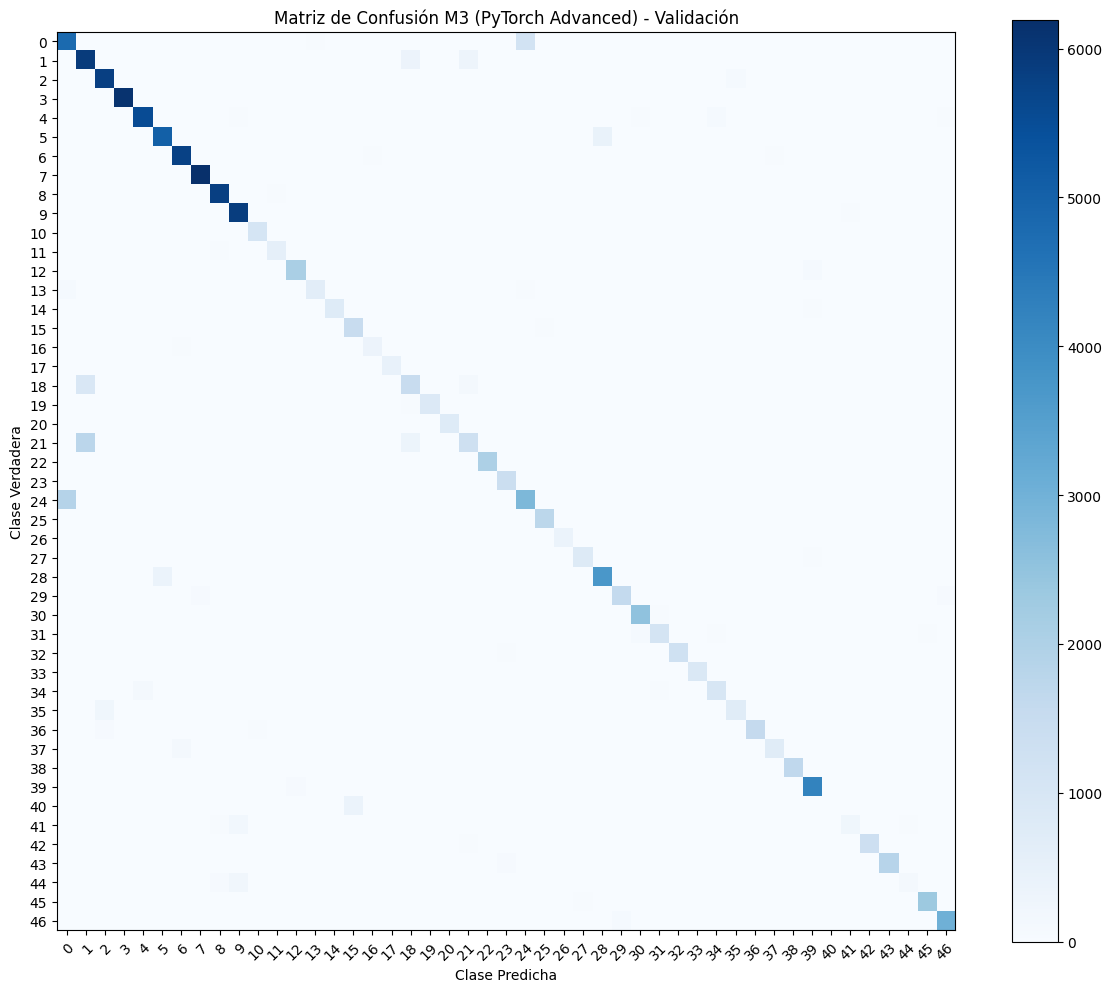

In [38]:
print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO M3 FINAL")
print("="*80)
print("Mejor configuración encontrada en experimentos anteriores\n")

model_m3_final = MLP_PyTorch_Advanced(
    input_size=784,
    hidden_sizes=BEST_M3_ARCH,
    num_classes=47,
    activation=BEST_M3_ACTIVATION,
    dropout_rate=BEST_M3_DROPOUT
)

trainer_m3_final = PyTorchTrainer(model_m3_final, device='cuda')
train_loader_m3_final, val_loader_m3_final = trainer_m3_final.prepare_data(
    X_train_flat, y_train, X_val_flat, y_val, batch_size=128
)

print(f"Arquitectura: {BEST_M3_ARCH}")
print(f"Activación: {BEST_M3_ACTIVATION.upper()}")
print(f"Dropout: {BEST_M3_DROPOUT}")
print(f"Parámetros: {sum(p.numel() for p in model_m3_final.parameters()):,}\n")

history_m3_final = trainer_m3_final.train(
    train_loader_m3_final, val_loader_m3_final,
    epochs=50, learning_rate=0.001, weight_decay=0.001,
    lr_schedule='exponential',
    lr_schedule_params={'decay_rate': 0.95},
    early_stopping_patience=20,
    verbose=True
)

y_pred_m3_final = trainer_m3_final.predict(X_val_flat)
metrics_M3_val = evaluate_model(y_val, y_pred_m3_final, n_classes=47, verbose=True)
metrics_M3_val['val_loss'] = history_m3_final['val_loss'][-1]

plot_confusion_matrix(metrics_M3_val['confusion_matrix'], 
                     title='Matriz de Confusión M3 (PyTorch Advanced) - Validación')
plt.show()

## 4.c) Comparación Final de los 4 Modelos en Test Set

In [45]:
mlp = MLP(n_layers=L+1, layer_sizes=layer_sizes, batch_size=batch_size, init=init_method)

history_M0 = mlp.train(
    X_train_T,  
    y_train_onehot,  
    X_val=X_val_T, 
    y_val=y_val_onehot,
    epochs=50, 
    learning_rate=learning_rate,
    verbose=True
)

Epoch 0/50 - LR: 0.010000 - Train Loss: 2.0068 - Val Loss: 1.2494
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.6085 - Val Loss: 0.5912
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.4959 - Val Loss: 0.4906
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.4466 - Val Loss: 0.4471
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4178 - Val Loss: 0.4214

Training completed. Best validation loss: 0.4083

TRAINING TIME SUMMARY
Total time: 267.73s (4.46 min)
Epochs trained: 50
Time per epoch: 5.35s



COMPARACIÓN DE LOS 4 MODELOS EN TEST SET (BASADO EN LOSS)

1. Calculando loss de M0 (Baseline Custom)...

2. Calculando loss de M1 (Mejor Custom con todas las optimizaciones)...

3. Calculando loss de M2 (PyTorch equivalente a M1)...

4. Calculando loss de M3 (PyTorch avanzado con GELU y Dropout)...

RESULTADOS EN TEST SET - COMPARACIÓN POR LOSS
          Modelo Test Loss
   M0 (Baseline)    0.4175
M1 (Best Custom)    0.3349
    M2 (PyTorch)    0.3875
   M3 (Advanced)    0.3437

🏆 Mejor modelo en TEST (menor loss): M1 (Best Custom)
   Test Loss: 0.3349


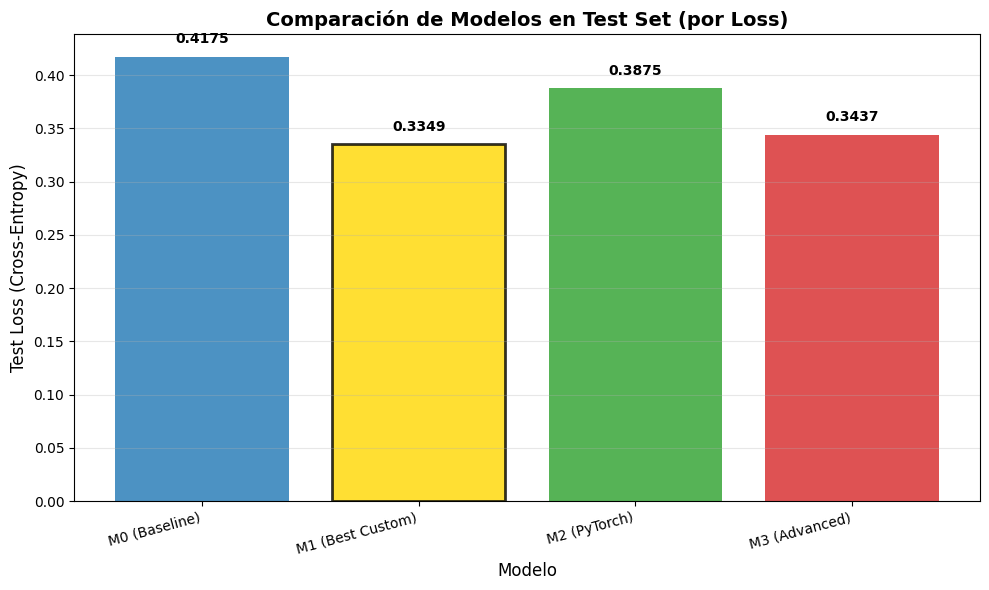


✓ Comparación completada
📊 Rango de losses: 0.3349 - 0.4175
📉 Diferencia mejor-peor: 0.0826


In [50]:
print("="*100)
print("COMPARACIÓN DE LOS 4 MODELOS EN TEST SET (BASADO EN LOSS)")
print("="*100)

# Preparar datos de test para GPU (CuPy)
X_test_T_gpu = cp.asarray(X_test_T)
y_test_onehot_gpu = cp.asarray(y_test_onehot)

print("\n1. Calculando loss de M0 (Baseline Custom)...")
y_pred_M0_test = mlp.forward(X_test_T_gpu)
loss_M0 = mlp.compute_loss(y_test_onehot_gpu, y_pred_M0_test, lambda_reg=0)
loss_M0 = float(cp.asnumpy(loss_M0))

print("\n2. Calculando loss de M1 (Mejor Custom con todas las optimizaciones)...")
y_pred_M1_test = model_m1_final.forward(X_test_T_gpu)
loss_M1 = model_m1_final.compute_loss(y_test_onehot_gpu, y_pred_M1_test, lambda_reg=0.001)
loss_M1 = float(cp.asnumpy(loss_M1))

print("\n3. Calculando loss de M2 (PyTorch equivalente a M1)...")
# Para PyTorch, usar la función de loss del trainer
import torch
X_test_torch = torch.FloatTensor(X_test_flat).to(trainer_m2.device)
y_test_torch = torch.LongTensor(y_test).to(trainer_m2.device)
model_m2.eval()
with torch.no_grad():
    outputs_M2 = model_m2(X_test_torch)
    loss_M2 = torch.nn.functional.cross_entropy(outputs_M2, y_test_torch).item()

print("\n4. Calculando loss de M3 (PyTorch avanzado con GELU y Dropout)...")
model_m3_final.eval()
with torch.no_grad():
    outputs_M3 = model_m3_final(X_test_torch)
    loss_M3 = torch.nn.functional.cross_entropy(outputs_M3, y_test_torch).item()

# Crear DataFrame de comparación
test_comparison = pd.DataFrame({
    'Modelo': ['M0 (Baseline)', 'M1 (Best Custom)', 'M2 (PyTorch)', 'M3 (Advanced)'],
    'Test Loss': [
        f"{loss_M0:.4f}",
        f"{loss_M1:.4f}",
        f"{loss_M2:.4f}",
        f"{loss_M3:.4f}"
    ]
})

print("\n" + "="*100)
print("RESULTADOS EN TEST SET - COMPARACIÓN POR LOSS")
print("="*100)
print(test_comparison.to_string(index=False))
print("="*100)

# Identificar mejor modelo (menor loss)
best_model_idx = test_comparison['Test Loss'].astype(float).idxmin()
print(f"\n🏆 Mejor modelo en TEST (menor loss): {test_comparison.loc[best_model_idx, 'Modelo']}")
print(f"   Test Loss: {test_comparison.loc[best_model_idx, 'Test Loss']}")

# Visualización
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
models = test_comparison['Modelo'].values
losses = test_comparison['Test Loss'].astype(float).values

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(models, losses, alpha=0.8, color=colors)

# Resaltar el mejor modelo
best_bar = bars[best_model_idx]
best_bar.set_color('gold')
best_bar.set_edgecolor('black')
best_bar.set_linewidth(2)

ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Test Loss (Cross-Entropy)', fontsize=12)
ax.set_title('Comparación de Modelos en Test Set (por Loss)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')

# Agregar valores sobre las barras
for i, (model, loss) in enumerate(zip(models, losses)):
    ax.text(i, loss + 0.01, f'{loss:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Comparación completada")
print(f"📊 Rango de losses: {losses.min():.4f} - {losses.max():.4f}")
print(f"📉 Diferencia mejor-peor: {(losses.max() - losses.min()):.4f}")

## 4.d) Test de Robustez con Ruido

Evaluar cómo se comportan los modelos frente a datos perturbados

In [54]:
def add_gaussian_noise(X, noise_level):
    """Agrega ruido gaussiano a los datos"""
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0, 1)

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]
robustness_results = []

print("="*100)
print("TEST DE ROBUSTEZ - Perturbación con Ruido Gaussiano (BASADO EN LOSS)")
print("="*100)

for noise_level in noise_levels:
    print(f"\nNivel de ruido: {noise_level:.2f}")
    
    # Crear datos con ruido
    X_test_noisy_flat = add_gaussian_noise(X_test_flat.copy(), noise_level)
    X_test_noisy_T = X_test_noisy_flat.T.astype(np.float32)
    
    # Calcular loss para cada modelo
    # M0 (CuPy)
    X_test_noisy_gpu = cp.asarray(X_test_noisy_T)
    y_pred_M0_noisy = mlp.forward(X_test_noisy_gpu)
    loss_M0_noisy = mlp.compute_loss(y_test_onehot_gpu, y_pred_M0_noisy, lambda_reg=0)
    loss_M0_noisy = float(cp.asnumpy(loss_M0_noisy))
    
    # M1 (CuPy)
    y_pred_M1_noisy = model_m1_final.forward(X_test_noisy_gpu)
    loss_M1_noisy = model_m1_final.compute_loss(y_test_onehot_gpu, y_pred_M1_noisy, lambda_reg=0.001)
    loss_M1_noisy = float(cp.asnumpy(loss_M1_noisy))
    
    # M2 (PyTorch)
    X_test_noisy_torch = torch.FloatTensor(X_test_noisy_flat).to(trainer_m2.device)
    model_m2.eval()
    with torch.no_grad():
        outputs_M2_noisy = model_m2(X_test_noisy_torch)
        loss_M2_noisy = torch.nn.functional.cross_entropy(outputs_M2_noisy, y_test_torch).item()
    
    # M3 (PyTorch)
    model_m3_final.eval()
    with torch.no_grad():
        outputs_M3_noisy = model_m3_final(X_test_noisy_torch)
        loss_M3_noisy = torch.nn.functional.cross_entropy(outputs_M3_noisy, y_test_torch).item()
    
    robustness_results.append({
        'Noise Level': f"{noise_level:.2f}",
        'M0 Loss': f"{loss_M0_noisy:.4f}",
        'M1 Loss': f"{loss_M1_noisy:.4f}",
        'M2 Loss': f"{loss_M2_noisy:.4f}",
        'M3 Loss': f"{loss_M3_noisy:.4f}"
    })

robustness_df = pd.DataFrame(robustness_results)
print("\n" + "="*100)
print("RESULTADOS DE ROBUSTEZ - LOSS CON DIFERENTES NIVELES DE RUIDO")
print("="*100)
print(robustness_df.to_string(index=False))
print("="*100)

# Análisis: encontrar el modelo más robusto (menor aumento de loss)
print("\n📊 Análisis de Robustez:")
noise_free_losses = {
    'M0': float(robustness_df['M0 Loss'].iloc[0]),
    'M1': float(robustness_df['M1 Loss'].iloc[0]),
    'M2': float(robustness_df['M2 Loss'].iloc[0]),
    'M3': float(robustness_df['M3 Loss'].iloc[0])
}
max_noise_losses = {
    'M0': float(robustness_df['M0 Loss'].iloc[-1]),
    'M1': float(robustness_df['M1 Loss'].iloc[-1]),
    'M2': float(robustness_df['M2 Loss'].iloc[-1]),
    'M3': float(robustness_df['M3 Loss'].iloc[-1])
}

print("\nAumento de loss (sin ruido → ruido máximo):")
for model in ['M0', 'M1', 'M2', 'M3']:
    increase = max_noise_losses[model] - noise_free_losses[model]
    increase_pct = (increase / noise_free_losses[model]) * 100
    print(f"  {model}: +{increase:.4f} (+{increase_pct:.2f}%)")

# El modelo más robusto es el que tiene menor aumento porcentual
increases = {model: (max_noise_losses[model] - noise_free_losses[model]) / noise_free_losses[model] * 100 
             for model in ['M0', 'M1', 'M2', 'M3']}
most_robust = min(increases, key=increases.get)
print(f"\n🏆 Modelo más robusto: {most_robust} (menor aumento de loss: +{increases[most_robust]:.2f}%)")

TEST DE ROBUSTEZ - Perturbación con Ruido Gaussiano (BASADO EN LOSS)

Nivel de ruido: 0.00

Nivel de ruido: 0.05

Nivel de ruido: 0.10

Nivel de ruido: 0.15

Nivel de ruido: 0.20

Nivel de ruido: 0.30

RESULTADOS DE ROBUSTEZ - LOSS CON DIFERENTES NIVELES DE RUIDO
Noise Level M0 Loss M1 Loss M2 Loss M3 Loss
       0.00  0.4175  0.3349  0.3875  0.3437
       0.05  0.4459  0.3599  0.4047  0.3678
       0.10  0.5759  0.5174  0.4612  0.4598
       0.15  0.9363  1.0038  0.5898  0.7054
       0.20  1.5612  1.7961  0.8389  1.1247
       0.30  3.4037  3.9640  1.7887  2.2700

📊 Análisis de Robustez:

Aumento de loss (sin ruido → ruido máximo):
  M0: +2.9862 (+715.26%)
  M1: +3.6291 (+1083.64%)
  M2: +1.4012 (+361.60%)
  M3: +1.9263 (+560.46%)

🏆 Modelo más robusto: M2 (menor aumento de loss: +361.60%)


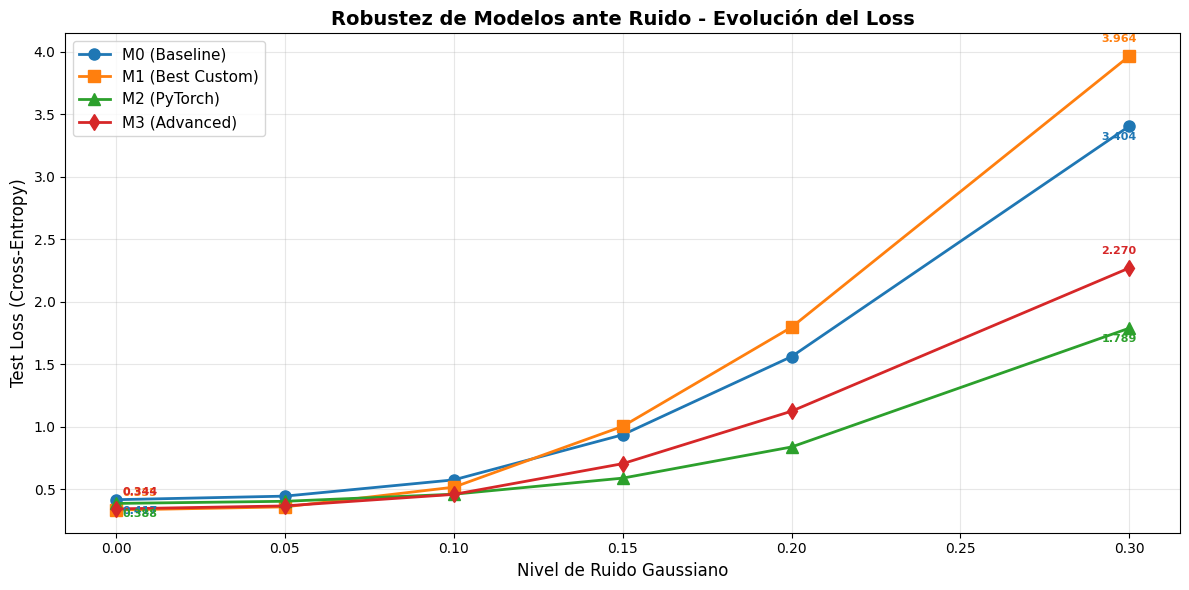


📈 Interpretación:
- Líneas más planas = Modelo más robusto (loss aumenta poco con ruido)
- Líneas más empinadas = Modelo menos robusto (loss aumenta mucho con ruido)
- Rango de ruido evaluado: 0.00 - 0.30


In [55]:
plt.figure(figsize=(12, 6))

# Extraer datos para graficar
noise_levels_plot = [float(x) for x in robustness_df['Noise Level']]
m0_loss = [float(x) for x in robustness_df['M0 Loss']]
m1_loss = [float(x) for x in robustness_df['M1 Loss']]
m2_loss = [float(x) for x in robustness_df['M2 Loss']]
m3_loss = [float(x) for x in robustness_df['M3 Loss']]

# Graficar las curvas de loss vs ruido
plt.plot(noise_levels_plot, m0_loss, marker='o', label='M0 (Baseline)', linewidth=2, markersize=8)
plt.plot(noise_levels_plot, m1_loss, marker='s', label='M1 (Best Custom)', linewidth=2, markersize=8)
plt.plot(noise_levels_plot, m2_loss, marker='^', label='M2 (PyTorch)', linewidth=2, markersize=8)
plt.plot(noise_levels_plot, m3_loss, marker='d', label='M3 (Advanced)', linewidth=2, markersize=8)

plt.xlabel('Nivel de Ruido Gaussiano', fontsize=12)
plt.ylabel('Test Loss (Cross-Entropy)', fontsize=12)
plt.title('Robustez de Modelos ante Ruido - Evolución del Loss', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)

# Agregar anotaciones en los puntos extremos
for i, (model_name, losses, color) in enumerate([
    ('M0', m0_loss, '#1f77b4'),
    ('M1', m1_loss, '#ff7f0e'),
    ('M2', m2_loss, '#2ca02c'),
    ('M3', m3_loss, '#d62728')
]):
    # Anotar valor inicial (sin ruido)
    plt.annotate(f'{losses[0]:.3f}', 
                xy=(noise_levels_plot[0], losses[0]),
                xytext=(5, -10 if i % 2 == 0 else 10),
                textcoords='offset points',
                fontsize=8, color=color, fontweight='bold')
    
    # Anotar valor final (ruido máximo)
    plt.annotate(f'{losses[-1]:.3f}', 
                xy=(noise_levels_plot[-1], losses[-1]),
                xytext=(-20, -10 if i % 2 == 0 else 10),
                textcoords='offset points',
                fontsize=8, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# Resumen visual adicional
print("\n📈 Interpretación:")
print("- Líneas más planas = Modelo más robusto (loss aumenta poco con ruido)")
print("- Líneas más empinadas = Modelo menos robusto (loss aumenta mucho con ruido)")
print(f"- Rango de ruido evaluado: {noise_levels_plot[0]:.2f} - {noise_levels_plot[-1]:.2f}")

# 5. Generación de Predicciones para Entrega

In [57]:
print("="*80)
print("GENERACIÓN DEL ARCHIVO predictions.csv")
print("="*80)

# Identificar el mejor modelo basado en MENOR LOSS (no mayor accuracy)
best_model_idx = test_comparison['Test Loss'].astype(float).idxmin()
best_model_name = test_comparison.loc[best_model_idx, 'Modelo']
best_model_loss = test_comparison.loc[best_model_idx, 'Test Loss']

print(f"\n🏆 Mejor modelo seleccionado: {best_model_name}")
print(f"   Test Loss: {best_model_loss}")
print(f"\nGenerando predicciones en el conjunto de test...")

# Generar predicciones según el mejor modelo
if best_model_idx == 0:  # M0
    print("   Usando M0 (Baseline Custom - CuPy)")
    predictions = cp.asnumpy(mlp.predict(cp.asarray(X_test_T)))
elif best_model_idx == 1:  # M1
    print("   Usando M1 (Best Custom - CuPy)")
    predictions = cp.asnumpy(model_m1_final.predict(cp.asarray(X_test_T)))
elif best_model_idx == 2:  # M2
    print("   Usando M2 (PyTorch)")
    predictions = trainer_m2.predict(X_test_flat)
else:  # M3
    print("   Usando M3 (Advanced PyTorch)")
    predictions = trainer_m3_final.predict(X_test_flat)

# Crear DataFrame con las predicciones
predictions_df = pd.DataFrame({
    'id': range(len(predictions)),
    'prediction': predictions
})

# Guardar archivo CSV
predictions_df.to_csv('predicciones.csv', index=False)

print(f"\n✓ Archivo 'predicciones.csv' generado exitosamente")
print(f"  Total de predicciones: {len(predictions):,}")
print(f"  Modelo utilizado: {best_model_name}")
print(f"  Loss del modelo: {best_model_loss}")

print(f"\n📊 Distribución de predicciones:")
unique_preds, counts_preds = np.unique(predictions, return_counts=True)

# Mostrar top 10 clases más predichas
print(f"  Total de clases únicas predichas: {len(unique_preds)}")
print(f"\n  Top 10 clases más predichas:")
sorted_indices = np.argsort(counts_preds)[::-1][:10]
for rank, idx in enumerate(sorted_indices, 1):
    pred_class = unique_preds[idx]
    count = counts_preds[idx]
    percentage = (count / len(predictions)) * 100
    print(f"    {rank}. Clase {pred_class}: {count:,} predicciones ({percentage:.2f}%)")

print(f"\n  Primeras 10 predicciones: {predictions[:10]}")
print(f"  Últimas 10 predicciones: {predictions[-10:]}")

print(f"\n✅ Archivo listo para entrega: predicciones.csv")

GENERACIÓN DEL ARCHIVO predictions.csv

🏆 Mejor modelo seleccionado: M1 (Best Custom)
   Test Loss: 0.3349

Generando predicciones en el conjunto de test...
   Usando M1 (Best Custom - CuPy)

✓ Archivo 'predicciones.csv' generado exitosamente
  Total de predicciones: 121,434
  Modelo utilizado: M1 (Best Custom)
  Loss del modelo: 0.3349

📊 Distribución de predicciones:
  Total de clases únicas predichas: 47

  Top 10 clases más predichas:
    1. Clase 1: 9,052 predicciones (7.45%)
    2. Clase 0: 6,996 predicciones (5.76%)
    3. Clase 7: 6,300 predicciones (5.19%)
    4. Clase 9: 6,136 predicciones (5.05%)
    5. Clase 3: 6,128 predicciones (5.05%)
    6. Clase 6: 6,116 predicciones (5.04%)
    7. Clase 2: 6,052 predicciones (4.98%)
    8. Clase 8: 6,039 predicciones (4.97%)
    9. Clase 4: 5,959 predicciones (4.91%)
    10. Clase 5: 5,265 predicciones (4.34%)

  Primeras 10 predicciones: [ 4 43  6  2 42  1  7  4  5 43]
  Últimas 10 predicciones: [32  1  1  7 12  5  9  1  5 30]

✅ Arc